# **New York City Yellow Taxi Data**

## Objective
In this case study we will be learning exploratory data analysis (EDA) with the help of a dataset on yellow taxi rides in New York City. This will enable you to understand why EDA is an important step in the process of data science and machine learning.

## **Problem Statement**
As an analyst at an upcoming taxi operation in NYC, you are tasked to use the 2023 taxi trip data to uncover insights that could help optimise taxi operations. The goal is to analyse patterns in the data that can inform strategic decisions to improve service efficiency, maximise revenue, and enhance passenger experience.

## Tasks
You need to perform the following steps for successfully completing this assignment:
1. Data Loading
2. Data Cleaning
3. Exploratory Analysis: Bivariate and Multivariate
4. Creating Visualisations to Support the Analysis
5. Deriving Insights and Stating Conclusions

---

---

## Data Understanding
The yellow taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

The data is stored in Parquet format (*.parquet*). The dataset is from 2009 to 2024. However, for this assignment, we will only be using the data from 2023.

The data for each month is present in a different parquet file. You will get twelve files for each of the months in 2023.

The data was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers like vendors and taxi hailing apps. <br>

You can find the link to the TLC trip records page here: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

###  Data Description
You can find the data description here: [Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

**Trip Records**



|Field Name       |description |
|:----------------|:-----------|
| VendorID | A code indicating the TPEP provider that provided the record. <br> 1= Creative Mobile Technologies, LLC; <br> 2= VeriFone Inc. |
| tpep_pickup_datetime | The date and time when the meter was engaged.  |
| tpep_dropoff_datetime | The date and time when the meter was disengaged.   |
| Passenger_count | The number of passengers in the vehicle. <br> This is a driver-entered value. |
| Trip_distance | The elapsed trip distance in miles reported by the taximeter. |
| PULocationID | TLC Taxi Zone in which the taximeter was engaged |
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged |
|RateCodeID |The final rate code in effect at the end of the trip.<br> 1 = Standard rate <br> 2 = JFK <br> 3 = Newark <br>4 = Nassau or Westchester <br>5 = Negotiated fare <br>6 = Group ride |
|Store_and_fwd_flag |This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.  <br>Y= store and forward trip <br>N= not a store and forward trip |
|Payment_type| A numeric code signifying how the passenger paid for the trip. <br> 1 = Credit card <br>2 = Cash <br>3 = No charge <br>4 = Dispute <br>5 = Unknown <br>6 = Voided trip |
|Fare_amount| The time-and-distance fare calculated by the meter. <br>Extra Miscellaneous extras and surcharges.  Currently, this only includes the 0.50 and 1 USD rush hour and overnight charges. |
|MTA_tax |0.50 USD MTA tax that is automatically triggered based on the metered rate in use. |
|Improvement_surcharge | 0.30 USD improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
|Tip_amount |Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip.  |
| total_amount | The total amount charged to passengers. Does not include cash tips. |
|Congestion_Surcharge |Total amount collected in trip for NYS congestion surcharge. |
| Airport_fee | 1.25 USD for pick up only at LaGuardia and John F. Kennedy Airports|

Although the amounts of extra charges and taxes applied are specified in the data dictionary, you will see that some cases have different values of these charges in the actual data.

**Taxi Zones**

Each of the trip records contains a field corresponding to the location of the pickup or drop-off of the trip, populated by numbers ranging from 1-263.

These numbers correspond to taxi zones, which may be downloaded as a table or map/shapefile and matched to the trip records using a join.

This is covered in more detail in later sections.

---

## **1** Data Preparation



### Import Libraries

In [11]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Import the libraries you will be using for analysis
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [4]:
# Recommended versions
# numpy version: 1.26.4
# pandas version: 2.2.2
# matplotlib version: 3.10.0
# seaborn version: 0.13.2

# Check versions
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)

numpy version: 1.26.4
pandas version: 2.2.2
matplotlib version: 3.10.0
seaborn version: 0.13.2


### **1.1** Load the dataset


You will see twelve files, one for each month.

To read parquet files with Pandas, you have to follow a similar syntax as that for CSV files.

`df = pd.read_parquet('file.parquet')`

In [132]:
# Try loading one file
df = pd.read_parquet('2023-1.parquet')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3041714 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee            floa

How many rows are there? Do you think handling such a large number of rows is computationally feasible when we have to combine the data for all twelve months into one?

To handle this, we need to sample a fraction of data from each of the files. How to go about that? Think of a way to select only some portion of the data from each month's file that accurately represents the trends.

#### Sampling the Data
> One way is to take a small percentage of entries for pickup in every hour of a date. So, for all the days in a month, we can iterate through the hours and select 5% values randomly from those. Use `tpep_pickup_datetime` for this. Separate date and hour from the datetime values and then for each date, select some fraction of trips for each of the 24 hours.

To sample data, you can use the `sample()` method. Follow this syntax:

```Python
# sampled_data is an empty DF to keep appending sampled data of each hour
# hour_data is the DF of entries for an hour 'X' on a date 'Y'

sample = hour_data.sample(frac = 0.05, random_state = 42)
# sample 0.05 of the hour_data
# random_state is just a seed for sampling, you can define it yourself

sampled_data = pd.concat([sampled_data, sample]) # adding data for this hour to the DF
```

This *sampled_data* will contain 5% values selected at random from each hour.

Note that the code given above is only the part that will be used for sampling and not the complete code required for sampling and combining the data files.

Keep in mind that you sample by date AND hour, not just hour. (Why?)

---

**1.1.1** 
Figure out how to sample and combine the files.

**Note:** It is not mandatory to use the method specified above. While sampling, you only need to make sure that your sampled data represents the overall data of all the months accurately.

In [ ]:
# Sample the data
# It is recommmended to not load all the files at once to avoid memory overload

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [136]:
import os

# Step 1: Set the directory where the 12 parquet files are stored
os.chdir(r"path\NYC_dataset")

# Step 2: Create a sorted list of all parquet files
file_list_temp = [f for f in os.listdir() if f.endswith('.parquet')]
file_list = sorted(file_list_temp, key=lambda x: int(x.split('-')[1].split('.')[0])) # to sort files numerically in ascending order

# Step 3: Initialize the final DataFrame to store all sampled data
df = pd.DataFrame()

# Step 4: Iterate through each monthly file
for file_name in file_list:
    try:
        print(f"Processing {file_name}...") # to keep a track on processing of for loop
        file_path = os.path.join(os.getcwd(), file_name)

        # Read current parquet file
        monthly_df = pd.read_parquet(file_path)

        # Ensure datetime is in correct format
        monthly_df['tpep_pickup_datetime'] = pd.to_datetime(monthly_df['tpep_pickup_datetime'])

        # Extract date and hour for grouping
        monthly_df['pickup_date'] = monthly_df['tpep_pickup_datetime'].dt.date
        monthly_df['pickup_hour'] = monthly_df['tpep_pickup_datetime'].dt.hour

        # Sample 0.75% of data per (date, hour) group (to keep approx 300,000 entries, use 0.0075 )
        sampled_data = (
            monthly_df.groupby(['pickup_date', 'pickup_hour'])
            .apply(lambda x: x.sample(frac=0.0075, random_state=42))
            .reset_index(drop=True)
        )

        # Append this month's sampled data to the final DataFrame
        df = pd.concat([df, sampled_data], ignore_index=True)

    except Exception as e:
        print(f"Error reading file {file_name}: {e}")


# Step 5: Final sampled DataFrame for the year is ready in `df`
print(f"\n✅ Sampling complete. Final shape: {df.shape}")

Processing 2023-1.parquet...
Processing 2023-2.parquet...
Processing 2023-3.parquet...
Processing 2023-4.parquet...
Processing 2023-5.parquet...
Processing 2023-6.parquet...
Processing 2023-7.parquet...
Processing 2023-8.parquet...
Processing 2023-9.parquet...
Processing 2023-10.parquet...
Processing 2023-11.parquet...
Processing 2023-12.parquet...

✅ Sampling complete. Final shape: (284492, 22)


After combining the data files into one DataFrame, convert the new DataFrame to a CSV or parquet file and store it to use directly.

Ideally, you can try keeping the total entries to around 250,000 to 300,000.

In [138]:
# Store the df in csv/parquet
df.to_parquet('sampled_nyc_data.parquet')

## **2** Data Cleaning


Now we can load the new data directly.

In [51]:
# Load the new data file
df = pd.read_parquet('sampled_nyc_data.parquet')


In [140]:
 df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_date,pickup_hour,Airport_fee
0,2,2023-01-01 00:07:18,2023-01-01 00:23:15,1.0,7.74,1.0,N,138,256,2,...,0.5,0.00,0.0,1.0,41.15,0.0,1.25,2023-01-01,0,NaN
1,2,2023-01-01 00:16:41,2023-01-01 00:21:46,2.0,1.24,1.0,N,161,237,1,...,0.5,2.58,0.0,1.0,15.48,2.5,0.00,2023-01-01,0,NaN
2,2,2023-01-01 00:14:03,2023-01-01 00:24:36,3.0,1.44,1.0,N,237,141,2,...,0.5,0.00,0.0,1.0,16.40,2.5,0.00,2023-01-01,0,NaN
3,2,2023-01-01 00:24:30,2023-01-01 00:29:55,1.0,0.54,1.0,N,143,142,2,...,0.5,0.00,0.0,1.0,11.50,2.5,0.00,2023-01-01,0,NaN
4,2,2023-01-01 00:43:00,2023-01-01 01:01:00,NaN,19.24,NaN,None,66,107,0,...,0.5,5.93,0.0,1.0,35.57,NaN,NaN,2023-01-01,0,NaN


In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284492 entries, 0 to 284491
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               284492 non-null  int64         
 1   tpep_pickup_datetime   284492 non-null  datetime64[us]
 2   tpep_dropoff_datetime  284492 non-null  datetime64[us]
 3   passenger_count        275065 non-null  float64       
 4   trip_distance          284492 non-null  float64       
 5   RatecodeID             275065 non-null  float64       
 6   store_and_fwd_flag     275065 non-null  object        
 7   PULocationID           284492 non-null  int64         
 8   DOLocationID           284492 non-null  int64         
 9   payment_type           284492 non-null  int64         
 10  fare_amount            284492 non-null  float64       
 11  extra                  284492 non-null  float64       
 12  mta_tax                284492 non-null  floa

#### **2.1** Fixing Columns


Fix/drop any columns as you seem necessary in the below sections

**2.1.1** 

Fix the index and drop unnecessary columns

In [144]:
# Fix the index and drop any columns that are not needed
# we can simply delete the 'pickup_date' and 'pickup_hour' column and continue with original columns
df = df.drop(['pickup_date','pickup_hour'], axis = 1)


In [146]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,Airport_fee
0,2,2023-01-01 00:07:18,2023-01-01 00:23:15,1.0,7.74,1.0,N,138,256,2,32.40,6.0,0.5,0.00,0.0,1.0,41.15,0.0,1.25,NaN
1,2,2023-01-01 00:16:41,2023-01-01 00:21:46,2.0,1.24,1.0,N,161,237,1,7.90,1.0,0.5,2.58,0.0,1.0,15.48,2.5,0.00,NaN
2,2,2023-01-01 00:14:03,2023-01-01 00:24:36,3.0,1.44,1.0,N,237,141,2,11.40,1.0,0.5,0.00,0.0,1.0,16.40,2.5,0.00,NaN
3,2,2023-01-01 00:24:30,2023-01-01 00:29:55,1.0,0.54,1.0,N,143,142,2,6.50,1.0,0.5,0.00,0.0,1.0,11.50,2.5,0.00,NaN
4,2,2023-01-01 00:43:00,2023-01-01 01:01:00,NaN,19.24,NaN,None,66,107,0,25.64,0.0,0.5,5.93,0.0,1.0,35.57,NaN,NaN,NaN


**2.1.2**
There are two airport fee columns. This is possibly an error in naming columns. Let's see whether these can be combined into a single column.

In [148]:
# Combine the two airport fee columns
df['airport_fee'] = df['airport_fee'].fillna(0)
df['Airport_fee'] = df['Airport_fee'].fillna(0)
df['Airport_Fee'] = df['airport_fee'] + df['Airport_fee']


In [150]:
df = df.drop(['airport_fee','Airport_fee'], axis = 1)

**2.1.3** 
Fix columns with negative (monetary) values

In [152]:
# check where values of fare amount are negative
# in the fare_amount column, there is no negative value in this sampled dataset
(df.fare_amount<0).sum()


0

In [71]:
(df.extra<0).sum()

1

In [73]:
(df.mta_tax<0).sum()

11

In [75]:
(df.tip_amount<0).sum()

0

In [77]:
(df.improvement_surcharge<0).sum()

11

In [79]:
(df.congestion_surcharge<0).sum()

6

Did you notice something different in the `RatecodeID` column for above records?

In [91]:
# Analyse RatecodeID for the negative fare amounts
# for column fare_amount
df[df['fare_amount'] < 0]['RatecodeID']


Series([], Name: RatecodeID, dtype: float64)

In [89]:
# for column extra
df[df['extra'] < 0]['RatecodeID']

230910    1.0
Name: RatecodeID, dtype: float64

In [83]:
# for column mta_tax, we see mostly the ratecodes are either 1 or 2
df[df['mta_tax'] < 0]['RatecodeID']

28938     1.0
68302     2.0
72605     2.0
73823     2.0
124392    1.0
147042    1.0
156024    1.0
237062    2.0
239854    1.0
253452    2.0
283068    1.0
Name: RatecodeID, dtype: float64

In [85]:
# for column congestion_surcharge, we see mostly the ratecodes are either 1 or 2
df[df['congestion_surcharge'] < 0]['RatecodeID']

68302     2.0
72605     2.0
73823     2.0
124392    1.0
237062    2.0
283068    1.0
Name: RatecodeID, dtype: float64

In [87]:
# for column improvement_surcharge, we see mostly the ratecodes are either 1 or 2
df[df['improvement_surcharge'] < 0]['RatecodeID']

28938     1.0
68302     2.0
72605     2.0
73823     2.0
124392    1.0
147042    1.0
156024    1.0
237062    2.0
239854    1.0
253452    2.0
283068    1.0
Name: RatecodeID, dtype: float64

In [95]:
# Find which columns have negative values
negative_cols = (df.select_dtypes(include='number') < 0).any()
negative_cols[negative_cols]

extra                    True
mta_tax                  True
improvement_surcharge    True
total_amount             True
congestion_surcharge     True
Airport_Fee              True
dtype: bool

In [154]:
# fix these negative values
#df['fare_amount'] = df['fare_amount'].clip(lower=0)
df['mta_tax'] = df['mta_tax'].clip(lower=0)
df['improvement_surcharge'] = df['improvement_surcharge'].clip(lower=0)
df['total_amount'] = df['total_amount'].clip(lower=0)
df['congestion_surcharge'] = df['congestion_surcharge'].clip(lower=0)
df['Airport_Fee'] = df['Airport_Fee'].clip(lower=0)
df['extra'] = df['extra'].clip(lower=0)


### **2.2** Handling Missing Values


**2.2.1**  
Find the proportion of missing values in each column




In [156]:
# Find the proportion of missing values in each column
df.isnull().mean()*100


VendorID                 0.000000
tpep_pickup_datetime     0.000000
tpep_dropoff_datetime    0.000000
passenger_count          3.313626
trip_distance            0.000000
RatecodeID               3.313626
store_and_fwd_flag       3.313626
PULocationID             0.000000
DOLocationID             0.000000
payment_type             0.000000
fare_amount              0.000000
extra                    0.000000
mta_tax                  0.000000
tip_amount               0.000000
tolls_amount             0.000000
improvement_surcharge    0.000000
total_amount             0.000000
congestion_surcharge     3.313626
Airport_Fee              0.000000
dtype: float64

**2.2.2** 
Handling missing values in `passenger_count`

In [158]:
# Display the rows with null values
df[df.passenger_count.isnull()]
# Impute NaN values in 'passenger_count'
MODE = df['passenger_count'].mode()
df['passenger_count'] =  df['passenger_count'].fillna(MODE[0])

Did you find zeroes in passenger_count? Handle these.

In [162]:
df['passenger_count'] = df['passenger_count'].astype(int)

In [164]:
df['passenger_count'].unique()

array([1, 2, 3, 4, 6, 5, 0, 9, 7, 8])

In [168]:
df['passenger_count'] = df['passenger_count'].replace(0,MODE[0])

**2.2.3**  
Handle missing values in `RatecodeID`

In [172]:
# Fix missing values in 'RatecodeID
MODE2 = df['RatecodeID'].mode()
df['RatecodeID'] = df['RatecodeID'].fillna(MODE2[0])

**2.2.4**  
Impute NaN in `congestion_surcharge`

In [174]:
# handle null values in congestion_surcharge
MODE3 = df['congestion_surcharge'].mode()
df['congestion_surcharge'] = df['congestion_surcharge'].fillna(MODE3[0])



Are there missing values in other columns? Did you find NaN values in some other set of columns? Handle those missing values below.

In [176]:
# Handle any remaining missing values
MODE4 = df['store_and_fwd_flag'].mode()
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].fillna(MODE4[0])



### **2.3** Handling Outliers


Before we start fixing outliers, let's perform outlier analysis.

In [178]:
# Describe the data and check if there are any potential outliers present
# Check for potential out of place values in various columns
df.describe()


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_Fee
count,284492.000000,284492,284492,284492.000000,284492.000000,284492.000000,284492.000000,284492.000000,284492.000000,284492.000000,284492.000000,284492.000000,284492.000000,284492.000000,284492.000000,284492.000000,284492.000000,284492.000000
mean,1.733349,2023-07-02 19:20:41.997792,2023-07-02 19:38:02.314908,1.370766,3.569540,1.634281,165.252106,163.953180,1.165094,19.817924,1.587169,0.495351,3.544263,0.592555,0.999038,28.873270,2.314758,0.137716
min,1.000000,2023-01-01 00:04:34,2023-01-01 00:09:40,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2023-04-02 15:36:21.500000,2023-04-02 15:53:39.500000,1.000000,1.050000,1.000000,132.000000,113.000000,1.000000,9.300000,0.000000,0.500000,1.000000,0.000000,1.000000,15.960000,2.500000,0.000000
50%,2.000000,2023-06-27 15:13:50,2023-06-27 15:29:38.500000,1.000000,1.800000,1.000000,162.000000,162.000000,1.000000,13.500000,1.000000,0.500000,2.840000,0.000000,1.000000,21.000000,2.500000,0.000000
75%,2.000000,2023-10-06 19:15:56.500000,2023-10-06 19:31:38,1.000000,3.400000,1.000000,234.000000,234.000000,1.000000,21.900000,2.500000,0.500000,4.420000,0.000000,1.000000,30.800000,2.500000,0.000000
max,6.000000,2023-12-31 23:54:03,2024-01-01 20:14:57,9.000000,22528.820000,99.000000,265.000000,265.000000,4.000000,910.000000,14.250000,0.800000,150.290000,143.000000,1.000000,911.000000,2.500000,1.750000
std,0.447582,NaN,NaN,0.863288,46.959114,7.408107,64.049104,69.773988,0.506215,18.203902,1.823733,0.048064,4.051388,2.175295,0.028606,22.759879,0.654823,0.456808


**2.3.1**
Based on the above analysis, it seems that some of the outliers are present due to errors in registering the trips. Fix the outliers.

Some points you can look for:
- Entries where `trip_distance` is nearly 0 and `fare_amount` is more than 300
- Entries where `trip_distance` and `fare_amount` are 0 but the pickup and dropoff zones are different (both distance and fare should not be zero for different zones)
- Entries where `trip_distance` is more than 250  miles.
- Entries where `payment_type` is 0 (there is no payment_type 0 defined in the data dictionary)

These are just some suggestions. You can handle outliers in any way you wish, using the insights from above outlier analysis.

How will you fix each of these values? Which ones will you drop and which ones will you replace?

First, let us remove 7+ passenger counts as there are very less instances.

In [180]:
# remove passenger_count > 6
df = df[~df.passenger_count.isin([7, 8, 9])]

In [182]:
# Continue with outlier handling
#VendorID
df['VendorID'].value_counts()


VendorID
2    208287
1     76132
6        68
Name: count, dtype: int64

In [186]:
MODE5 = df['VendorID'].mode()
df['VendorID'] = df['VendorID'].replace(6,MODE5[0])

In [190]:
df['VendorID'].value_counts()

VendorID
2    208355
1     76132
Name: count, dtype: int64

In [194]:
#trip_distance column
#1. Entries where trip_distance is nearly 0 and fare_amount is more than 300 and checking if they are airport trips 
df.loc[(df.trip_distance<0.1) & (df.fare_amount>300),['trip_distance','fare_amount','Airport_Fee']]

,trip_distance,fare_amount,Airport_Fee
64998,0.0,500.0,0.0
71856,0.0,350.0,0.0
99838,0.0,910.0,0.0
119227,0.0,600.0,0.0
265715,0.0,319.0,0.0
280364,0.0,417.0,0.0


In [196]:
# seems like anomalies, so we can drop these instances/trips
df = df[~((df.trip_distance<0.1) & (df.fare_amount>300))]

In [198]:
# 2.Entries where trip_distance and fare_amount are 0 but the pickup and dropoff zones are different
#(both distance and fare should not be zero for different zones)

df = df[~((df['trip_distance'] == 0) & 
          (df['fare_amount'] == 0) & 
          (df['PULocationID'] != df['DOLocationID']))]


In [200]:
#Entries where trip_distance is more than 250 miles.
df = df[~(df.trip_distance>250)]


In [202]:
# Entries where payment_type is 0
df['payment_type'] = df['payment_type'].replace(0,5)


In [223]:
#Entries with trip_distance = 0 but the pickup and dropoff zones are different
df = df[~(df['trip_distance'] == 0) & 
          (df['PULocationID'] != df['DOLocationID'])]

In [239]:
# Entries with RatecodeID = 99 can be dropped 
df = df[~(df['RatecodeID']==99)]

In [ ]:
# Do any columns need standardising?



In [214]:
# Adding pickup_hour column for EDA
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour


## **3** Exploratory Data Analysis


In [216]:
df.columns.tolist()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'Airport_Fee',
 'pickup_hour']

#### **3.1** General EDA: Finding Patterns and Trends


**3.1.1**
Categorise the varaibles into Numerical or Categorical.
* `VendorID`: Categorical
* `tpep_pickup_datetime`: Datetime
* `tpep_dropoff_datetime`: Datetime
* `passenger_count`: Numerical
* `trip_distance`: Numerical
* `RatecodeID`: Categorical
* `PULocationID`: Categorical
* `DOLocationID`: Categorical
* `payment_type`: Categorical
* `pickup_hour`: Numerical
* `trip_duration`: Numerical


The following monetary parameters belong in the same category, is it categorical or numerical?


* `fare_amount`: Numerical
* `extra`: Numerical
* `mta_tax`: Numerical
* `tip_amount`: Numerical
* `tolls_amount`: Numerical
* `improvement_surcharge`: Numerical
* `total_amount`: Numerical
* `congestion_surcharge`: Numerical
* `airport_fee`: Numerical

##### Temporal Analysis

**3.1.2** 
Analyse the distribution of taxi pickups by hours, days of the week, and months.

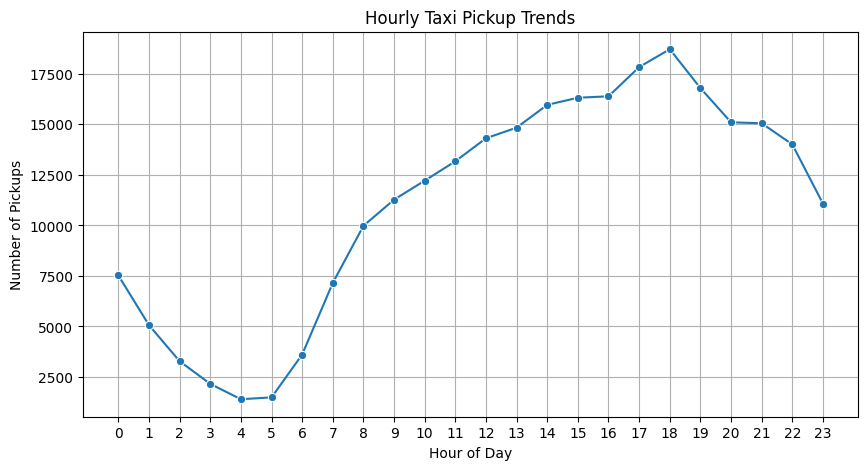

In [243]:
# Find and show the hourly trends in taxi pickups
# Group by hour and count pickups
hourly_trend = df.groupby('pickup_hour').size()

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(x=hourly_trend.index, y=hourly_trend.values, marker = 'o')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Pickups')
plt.title('Hourly Taxi Pickup Trends')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()


In [245]:
df['pickup_date'] = df['tpep_pickup_datetime'].dt.date

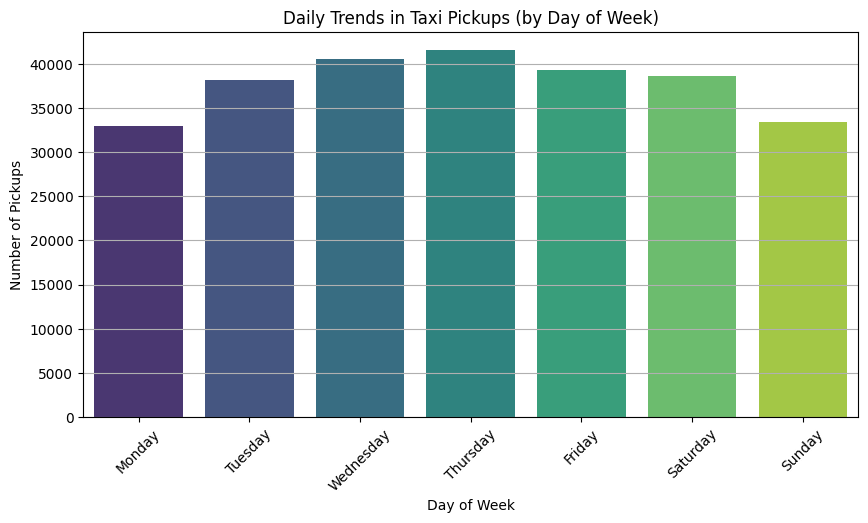

In [247]:
# Find and show the daily trends in taxi pickups (days of the week)
# Step 1: Create a column for the day of the week
df['pickup_dayofweek'] = df['tpep_pickup_datetime'].dt.day_name()

# Step 2: Count the number of pickups per day
pickup_counts = df['pickup_dayofweek'].value_counts().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

# Step 3: Plot the trend
plt.figure(figsize=(10, 5))
sns.barplot(x=pickup_counts.index, y=pickup_counts.values, palette="viridis")
plt.title("Daily Trends in Taxi Pickups (by Day of Week)")
plt.xlabel("Day of Week")
plt.ylabel("Number of Pickups")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

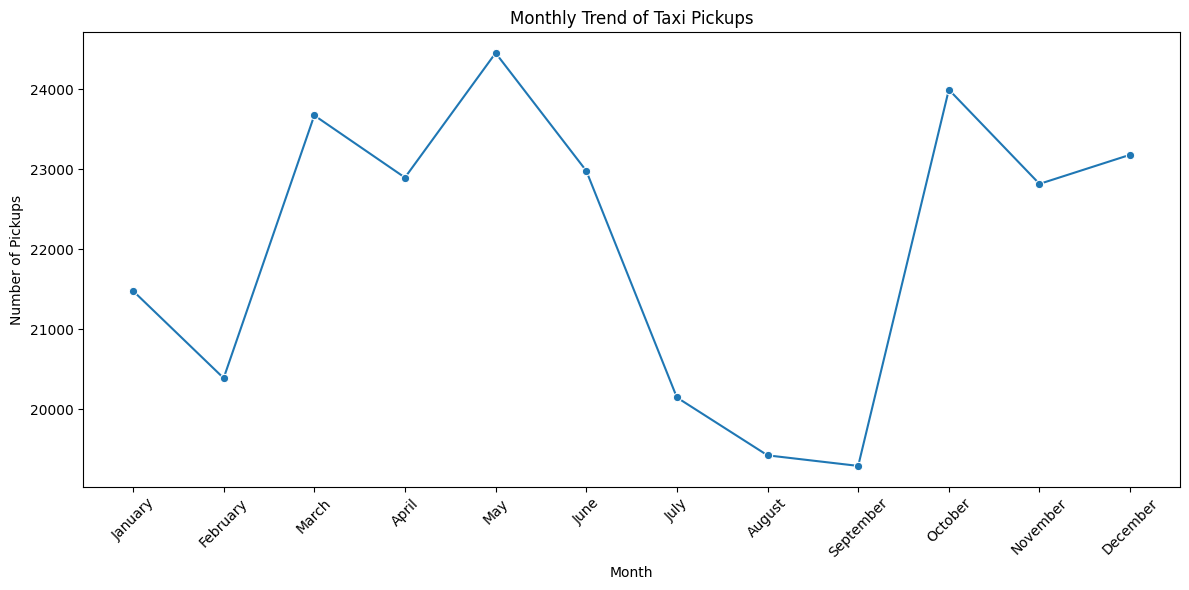

In [249]:
# Show the monthly trends in pickups
# Step 1: Create a column for the pick up months
df['pickup_month'] = df['tpep_pickup_datetime'].dt.month_name()

# Step 2: Count the number of pickups per month
pickup_counts = df['pickup_month'].value_counts().reindex([
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
])

plt.figure(figsize=(12, 6))
sns.lineplot(x=pickup_counts.index, y=pickup_counts.values, marker='o')
plt.title("Monthly Trend of Taxi Pickups")
plt.xlabel("Month")
plt.ylabel("Number of Pickups")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##### Financial Analysis

Take a look at the financial parameters like `fare_amount`, `tip_amount`, `total_amount`, and also `trip_distance`. Do these contain zero/negative values?

In [251]:
# Analyse the above parameters

# check for any zero value and negative values in the columns fare_amount, tip_amount, total_amount, and also trip_distance

(df.select_dtypes(include = 'number') < 0).sum()
(df.select_dtypes(include='number') == 0).sum()

VendorID                      0
passenger_count               0
trip_distance                 0
RatecodeID                    0
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                  33
extra                    101859
mta_tax                    1592
tip_amount                55701
tolls_amount             242612
improvement_surcharge        14
total_amount                 10
congestion_surcharge      16203
Airport_Fee              241319
pickup_hour                7523
dtype: int64

Do you think it is beneficial to create a copy DataFrame leaving out the zero values from these?

**3.1.3**
Filter out the zero values from the above columns.

**Note:** The distance might be 0 in cases where pickup and drop is in the same zone. Do you think it is suitable to drop such cases of zero distance?

In [253]:
# Create a df with non zero entries for the selected parameters.
filtered_df = df[(df['fare_amount'] > 0) & 
                 (df['tip_amount'] > 0) & 
                 (df['total_amount'] > 0) & 
                 (df['trip_distance'] > 0)]


**3.1.4** 
Analyse the monthly revenue (`total_amount`) trend

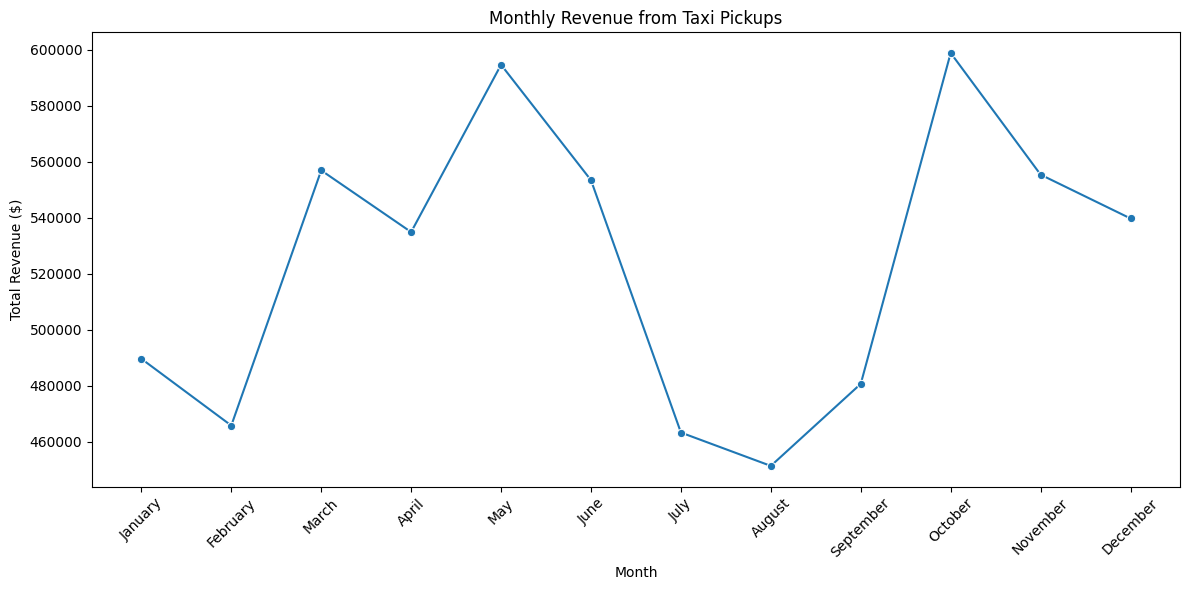

In [257]:
# Group data by month and analyse monthly revenue

# Step 1: Group by pickup month and calculate total revenue
monthly_revenue = filtered_df.groupby('pickup_month')['total_amount'].sum().reindex([
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
])

# Step 2: Plot the monthly revenue
plt.figure(figsize=(12, 6))
sns.lineplot(x=monthly_revenue.index, y=monthly_revenue.values, marker='o')
plt.title("Monthly Revenue from Taxi Pickups")
plt.xlabel("Month")
plt.ylabel("Total Revenue ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**3.1.5** 
Show the proportion of each quarter of the year in the revenue

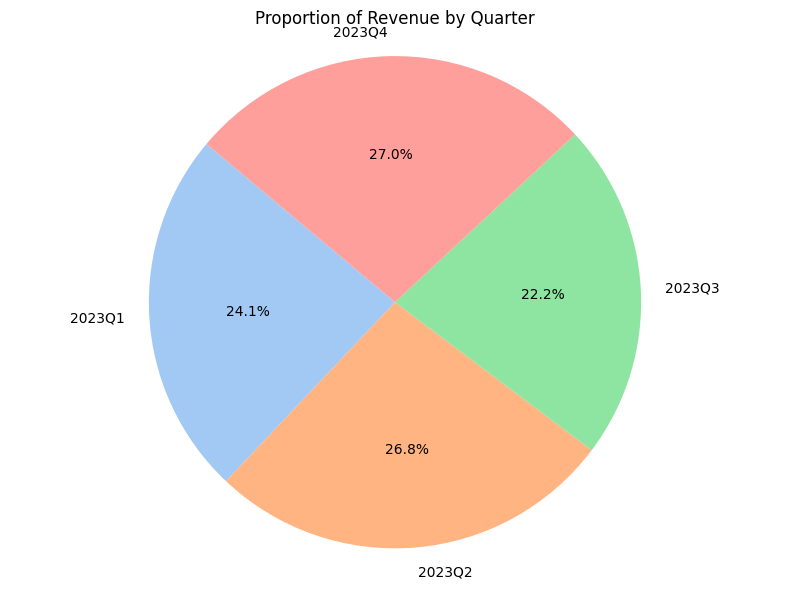

In [259]:
# Calculate proportion of each quarter
# Step 1: Create a 'quarter' column
filtered_df['pickup_quarter'] = filtered_df['tpep_pickup_datetime'].dt.to_period('Q').astype(str)

# Step 2: Group by quarter and sum the total revenue
quarterly_revenue = filtered_df.groupby('pickup_quarter')['total_amount'].sum()

# Step 3: Calculate proportion of each quarter
quarterly_proportion = (quarterly_revenue / quarterly_revenue.sum()) * 100

# Step 4: Plot as pie chart
plt.figure(figsize=(8, 6))
plt.pie(quarterly_proportion, labels=quarterly_proportion.index, 
        autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title("Proportion of Revenue by Quarter")
plt.axis('equal')  # Equal aspect ratio ensures pie is a circle.
plt.tight_layout()
plt.show()


**3.1.6** 
Visualise the relationship between `trip_distance` and `fare_amount`. Also find the correlation value for these two.

**Hint:** You can leave out the trips with trip_distance = 0

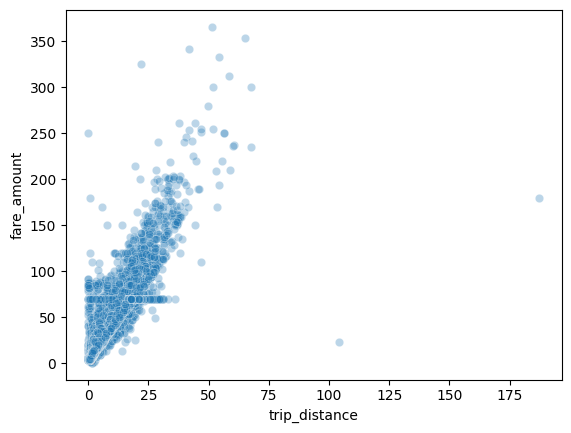

In [263]:
# Show how trip fare is affected by distance
sns.scatterplot(data=filtered_df, x='trip_distance', y='fare_amount', alpha=0.3)
plt.show()

In [290]:
# There is a very strong positive correlation between trip_distance and fare_amount feature
correlation = filtered_df['trip_distance'].corr(filtered_df['fare_amount'])
np.round(correlation,4)

0.9532

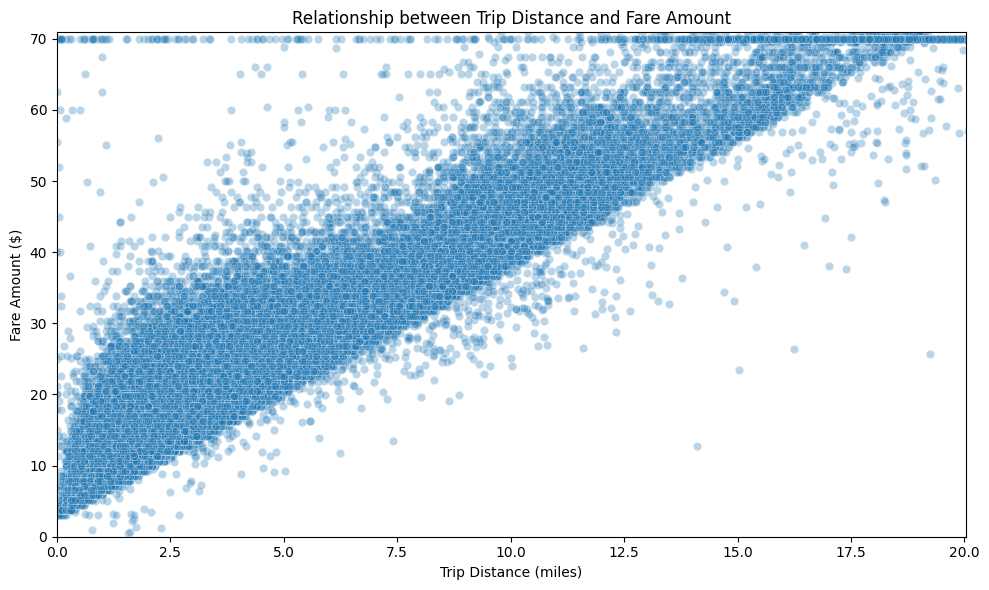

In [276]:
# trip_distance between range 0 to 20 miles clearly indicate strong positive correlation between trip_distnace and fare_amount

plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_df, x='trip_distance', y='fare_amount', alpha=0.3)
plt.title("Relationship between Trip Distance and Fare Amount")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Fare Amount ($)")
plt.xlim(0, filtered_df['trip_distance'].quantile(0.99))  # Optional: limit extreme outliers
plt.ylim(0, filtered_df['fare_amount'].quantile(0.99))
plt.tight_layout()
plt.show()

**3.1.7**
Find and visualise the correlation between:
1. `fare_amount` and trip duration (pickup time to dropoff time)
2. `fare_amount` and `passenger_count`
3. `tip_amount` and `trip_distance`

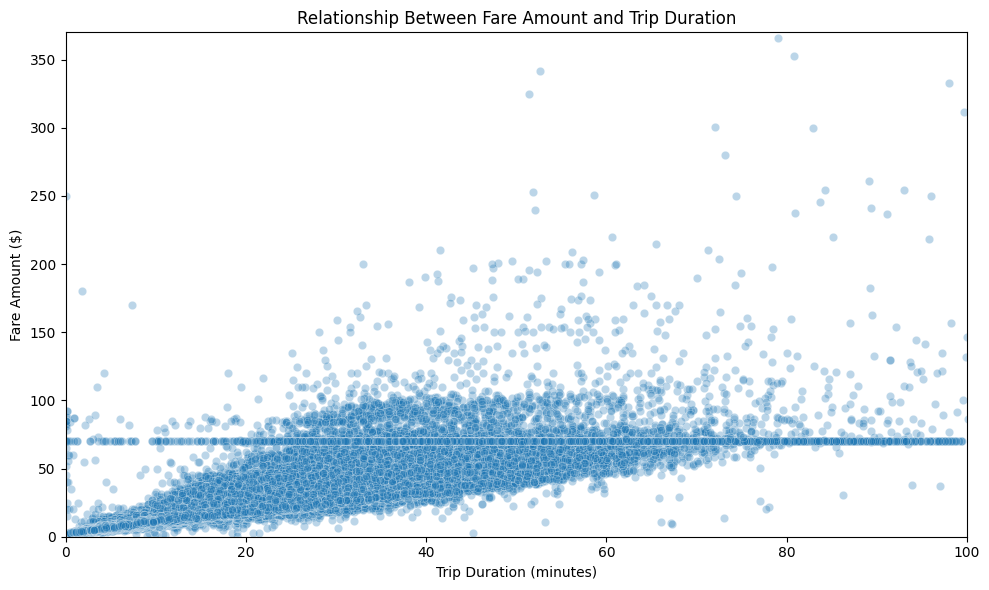

In [292]:
# Show relationship between fare and trip duration
filtered_df['trip_duration'] = (filtered_df['tpep_dropoff_datetime'] - filtered_df['tpep_pickup_datetime']).dt.total_seconds() / 60
filtered_df = filtered_df[~(filtered_df['trip_duration']<0)]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='trip_duration', y='fare_amount', data=filtered_df, alpha=0.3)
plt.title("Relationship Between Fare Amount and Trip Duration")
plt.xlabel("Trip Duration (minutes)")
plt.ylabel("Fare Amount ($)")
plt.xlim(0, 100)  # Optional: limit duration for better visibility
plt.ylim(0, 370)  # Optional: limit fare for better visibility
plt.tight_layout()
plt.show()



In [294]:
# There is a weak positive correlation between the trip_duration and fare_amount feature
correlation = filtered_df['trip_duration'].corr(filtered_df['fare_amount'])
np.round(correlation,4)

0.3398

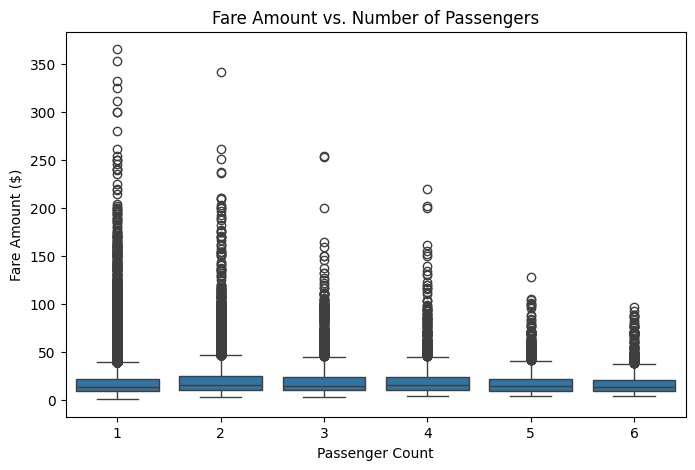

In [298]:
# Show relationship between fare and number of passengers
plt.figure(figsize=(8, 5))
sns.boxplot(x='passenger_count', y='fare_amount', data=filtered_df)
plt.title("Fare Amount vs. Number of Passengers")
plt.xlabel("Passenger Count")
plt.ylabel("Fare Amount ($)")
# plt.ylim(0, 100)  # Optional: to reduce effect of extreme outliers
plt.show()

In [302]:
# There is a negligible positive correlation between the Passenger count and fare_amount feature
correlation = filtered_df['passenger_count'].corr(filtered_df['fare_amount'])
np.round(correlation,4)

0.0351

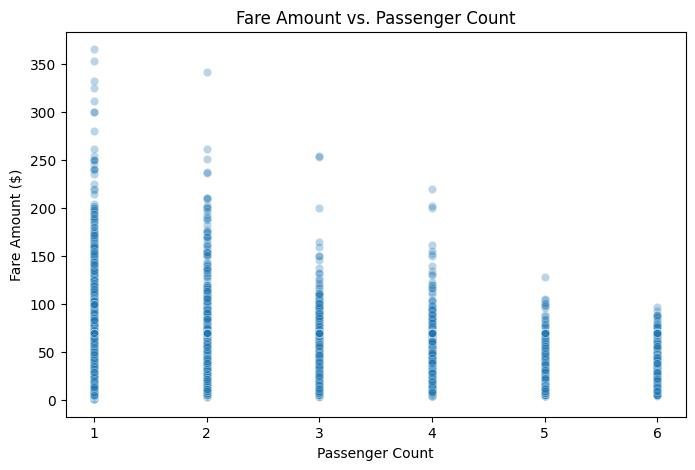

In [300]:
# to understand correlation, we may use scatterplot
plt.figure(figsize=(8, 5))
sns.scatterplot(x='passenger_count', y='fare_amount', data=filtered_df, alpha=0.3)
plt.title("Fare Amount vs. Passenger Count")
plt.xlabel("Passenger Count")
plt.ylabel("Fare Amount ($)")
plt.show()

In [ ]:
# There is a weak positive correlation between the trip_duration and fare_amount feature
correlation = filtered_df['trip_duration'].corr(filtered_df['fare_amount'])
np.round(correlation,4)

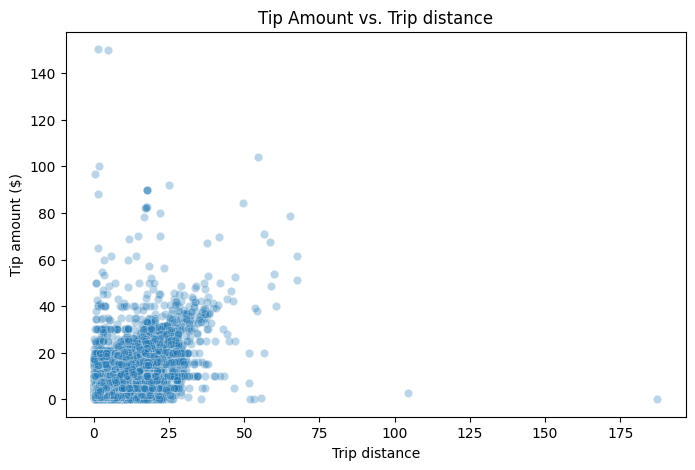

In [312]:
# Show relationship between tip and trip distance
plt.figure(figsize=(8, 5))
sns.scatterplot(x='trip_distance', y='tip_amount', data=filtered_df, alpha=0.3)
plt.title("Tip Amount vs. Trip distance")
plt.xlabel("Trip distance")
plt.ylabel("Tip amount ($)")
# plt.xlim(0,100)
# plt.ylim(0, 120)
plt.show()


In [306]:
# There is a strong positive correlation between the trip_duration and Tip amount feature
correlation = filtered_df['tip_amount'].corr(filtered_df['trip_distance'])
np.round(correlation,4)

0.7997

**3.1.8**
Analyse the distribution of different payment types (`payment_type`)

In [332]:
filtered_df.payment_type.value_counts()

payment_type
1    203656
5      5356
2         5
4         3
Name: count, dtype: int64

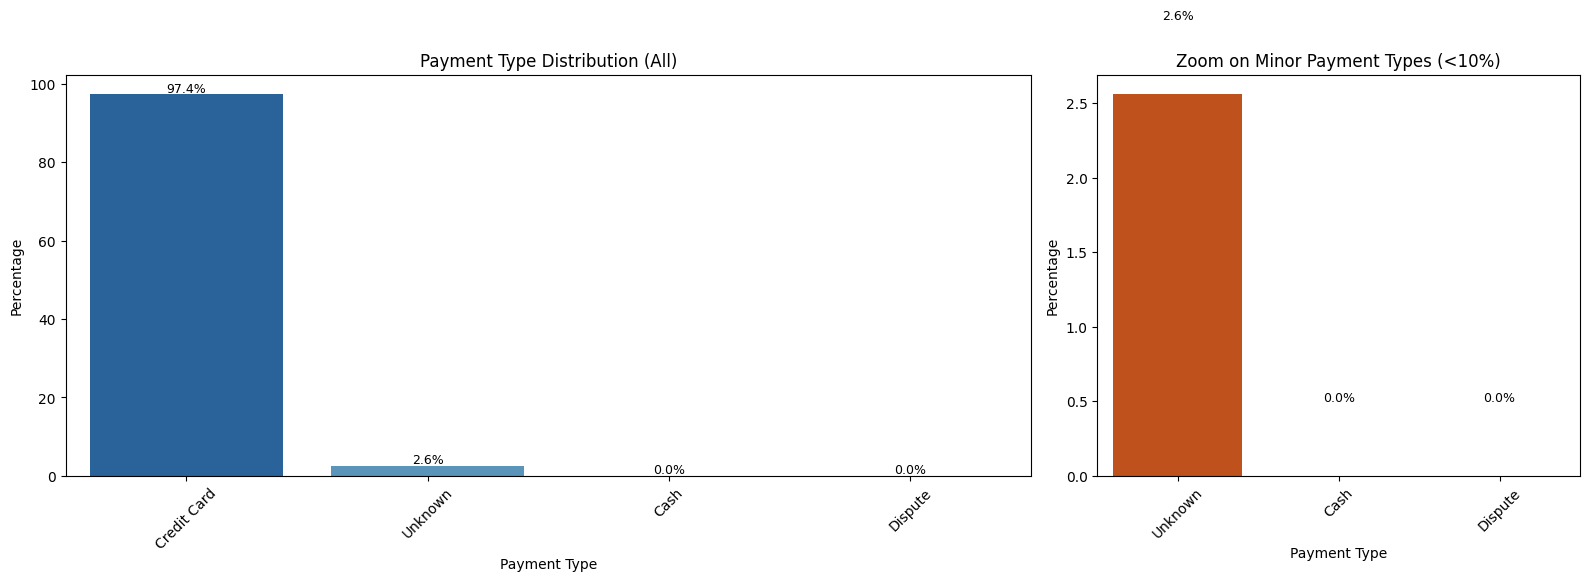

In [330]:
# Analyse the distribution of different payment types (payment_type).
payment_map = {
    1: 'Credit card',
    2: 'Cash',
    3: 'No charge',
    4: 'Dispute',
    5: 'Unknown',
   }

df['payment_type_label'] = df['payment_type'].map(payment_map)

# Get value counts
payment_counts = filtered_df['payment_type_label'].value_counts()
payment_percent = (payment_counts / payment_counts.sum()) * 100

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [2, 1]})

# Main Plot: All Categories
sns.barplot(x=payment_percent.index, y=payment_percent.values, ax=axes[0], palette='Blues_r')
axes[0].set_title('Payment Type Distribution (All)')
axes[0].set_ylabel('Percentage')
axes[0].set_xlabel('Payment Type')
axes[0].tick_params(axis='x', rotation=45)
for i, v in enumerate(payment_percent.values):
    axes[0].text(i, v + 0.5, f"{v:.1f}%", ha='center', fontsize=9)

# Secondary Plot: Only Minor Categories (<10%)
minor_types = payment_percent[payment_percent < 10]
sns.barplot(x=minor_types.index, y=minor_types.values, ax=axes[1], palette='Oranges_r')
axes[1].set_title('Zoom on Minor Payment Types (<10%)')
axes[1].set_ylabel('Percentage')
axes[1].set_xlabel('Payment Type')
axes[1].tick_params(axis='x', rotation=45)
for i, v in enumerate(minor_types.values):
    axes[1].text(i, v + 0.5, f"{v:.1f}%", ha='center', fontsize=9)

plt.tight_layout()
plt.show()




- 1= Credit card
- 2= Cash
- 3= No charge
- 4= Dispute



##### Geographical Analysis

For this, you have to use the *taxi_zones.shp* file from the *taxi_zones* folder.

There would be multiple files inside the folder (such as *.shx, .sbx, .sbn* etc). You do not need to import/read any of the files other than the shapefile, *taxi_zones.shp*.

Do not change any folder structure - all the files need to be present inside the folder for it to work.

The folder structure should look like this:
```
Taxi Zones
|- taxi_zones.shp.xml
|- taxi_zones.prj
|- taxi_zones.sbn
|- taxi_zones.shp
|- taxi_zones.dbf
|- taxi_zones.shx
|- taxi_zones.sbx

 ```

 You only need to read the `taxi_zones.shp` file. The *shp* file will utilise the other files by itself.

We will use the *GeoPandas* library for geopgraphical analysis
```
import geopandas as gpd
```

More about geopandas and shapefiles: [About](https://geopandas.org/en/stable/about.html)


Reading the shapefile is very similar to *Pandas*. Use `gpd.read_file()` function to load the data (*taxi_zones.shp*) as a GeoDataFrame. Documentation: [Reading and Writing Files](https://geopandas.org/en/stable/docs/user_guide/io.html)

In [335]:
 !pip install geopandas

   ---------------------------------------- 0.0/323.6 kB ? eta -:--:--
   - -------------------------------------- 10.2/323.6 kB ? eta -:--:--
   ---- ---------------------------------- 41.0/323.6 kB 393.8 kB/s eta 0:00:01
   -------- ------------------------------ 71.7/323.6 kB 491.5 kB/s eta 0:00:01
   -------------- ----------------------- 122.9/323.6 kB 599.1 kB/s eta 0:00:01
   -------------------- ----------------- 174.1/323.6 kB 697.2 kB/s eta 0:00:01
   -------------------------- ----------- 225.3/323.6 kB 762.6 kB/s eta 0:00:01
   --------------------------------- ---- 286.7/323.6 kB 842.9 kB/s eta 0:00:01
   -------------------------------------- 323.6/323.6 kB 835.6 kB/s eta 0:00:00
   ---------------------------------------- 0.0/16.2 MB ? eta -:--:--
   ---------------------------------------- 0.1/16.2 MB 1.6 MB/s eta 0:00:11
   ---------------------------------------- 0.1/16.2 MB 1.3 MB/s eta 0:00:13
   ---------------------------------------- 0.2/16.2 MB 1.2 MB/s eta 0:00

**3.1.9** 
Load the shapefile and display it.

In [339]:
os.getcwd()
os.chdir('path\Taxi_zones_dataset')

In [341]:
 import geopandas as gpd


# Read the shapefile using geopandas
zones = gpd.read_file('taxi_zones.shp')
zones.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144..."


Now, if you look at the DataFrame created, you will see columns like: `OBJECTID`,`Shape_Leng`, `Shape_Area`, `zone`, `LocationID`, `borough`, `geometry`.
<br><br>

Now, the `locationID` here is also what we are using to mark pickup and drop zones in the trip records.

The geometric parameters like shape length, shape area and geometry are used to plot the zones on a map.

This can be easily done using the `plot()` method.

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int32   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int32   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int32(2), object(2)
memory usage: 12.5+ KB
None


<Axes: >

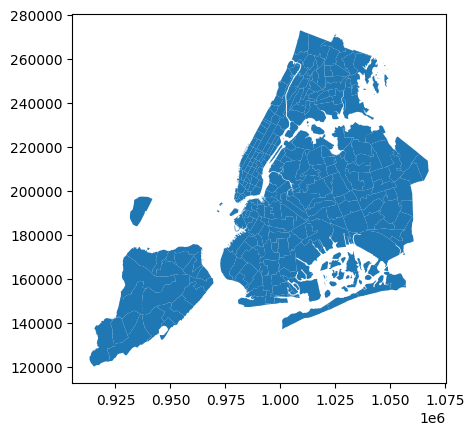

In [343]:
 print(zones.info())
zones.plot()

Now, you have to merge the trip records and zones data using the location IDs.



**3.1.10** 
Merge the zones data into trip data using the `locationID` and `PULocationID` columns.

In [347]:
# Merge zones and trip records using locationID and PULocationID

# Make sure your trip data has PULocationID as integer
filtered_df['PULocationID'] = filtered_df['PULocationID'].astype(int)

# Merge the trips DataFrame with zones GeoDataFrame
df_merged = filtered_df.merge(zones, how='left', left_on='PULocationID', right_on='LocationID')
df_merged = df_merged[df_merged['PULocationID'] !=264]
df_merged = df_merged[df_merged['PULocationID'] !=265]

**3.1.11**
Group data by location IDs to find the total number of trips per location ID

In [378]:
# Group data by location and calculate the number of trips
df_merged['LocationID'] = df_merged['LocationID'].astype(int) # converting the column to int type

# Step 1: Count the number of trips per location
trip_counts = df_merged['LocationID'].value_counts().reset_index()
trip_counts.columns = ['LocationID', 'trip_count']

**3.1.12** 
Now, use the grouped data to add number of trips to the GeoDataFrame.

We will use this to plot a map of zones showing total trips per zone.

In [ ]:
# Merge trip counts back to the zones GeoDataFrame

# Step 1: Merge with the zones GeoDataFrame on LocationID
zones_merged = zones.merge(trip_counts, how='left', left_on='LocationID', right_on='LocationID')

zones_merged.rename(columns={'count': 'trip_count'}, inplace=True)

# Step 2: Fill NaN trip counts with 0 (for zones with no pickups)
zones_merged['trip_count'] = zones_merged['trip_count'].fillna(0)

The next step is creating a color map (choropleth map) showing zones by the number of trips taken.

Again, you can use the `zones.plot()` method for this. [Plot Method GPD](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)

But first, you need to define the figure and axis for the plot.

`fig, ax = plt.subplots(1, 1, figsize = (12, 10))`

This function creates a figure (fig) and a single subplot (ax)

---

After setting up the figure and axis, we can proceed to plot the GeoDataFrame on this axis. This is done in the next step where we use the plot method of the GeoDataFrame.

You can define the following parameters in the `zones.plot()` method:
```
column = '',
ax = ax,
legend = True,
legend_kwds = {'label': "label", 'orientation': "<horizontal/vertical>"}
```

To display the plot, use `plt.show()`.

**3.1.13** 
Plot a color-coded map showing zone-wise trips

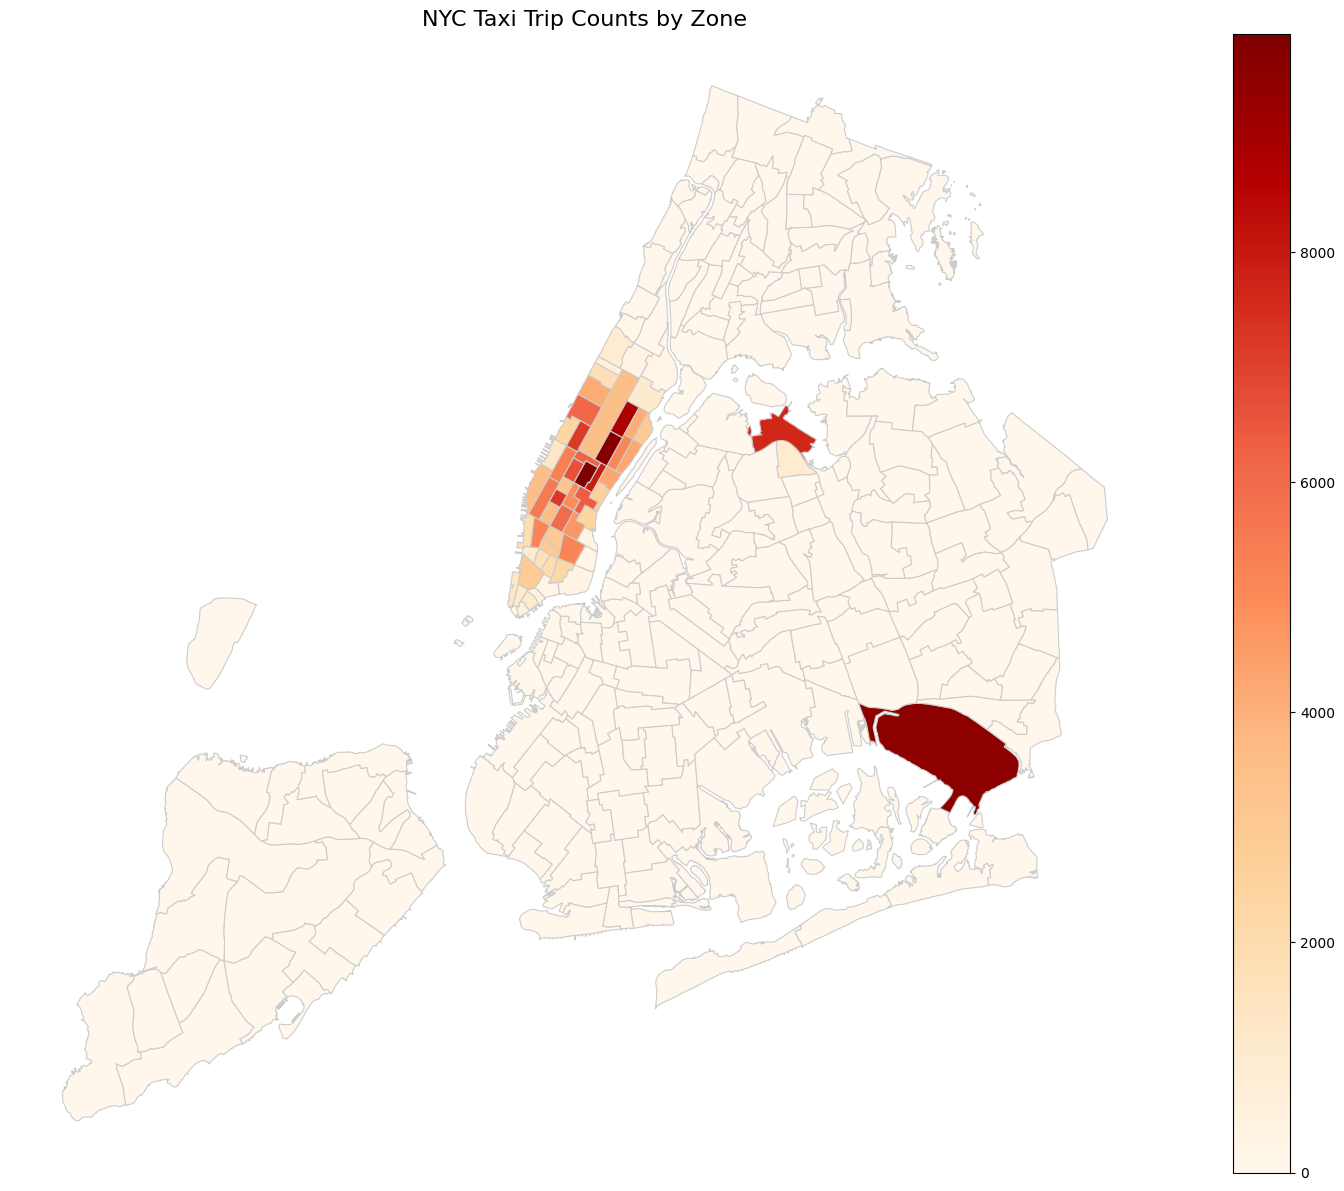

In [388]:
# Define figure and axis
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Plot the map and display it
zones_merged.plot(column='trip_count',
           cmap='OrRd',
           linewidth=0.8,
           ax=ax,
           edgecolor='0.8',
           legend=True)

# Title and styling
ax.set_title('NYC Taxi Trip Counts by Zone', fontdict={'fontsize': 16})
ax.axis('off')
plt.tight_layout()
plt.show()

In [390]:
# can you try displaying the zones DF sorted by the number of trips?
# Sort zones by trip count in descending order
sorted_zones = zones_merged.sort_values(by='trip_count', ascending=False)

# Display the top rows
print(sorted_zones[['LocationID', 'zone', 'trip_count']].head(10))


     LocationID                          zone  trip_count
160         161                Midtown Center      9899.0
236         237         Upper East Side South      9761.0
131         132                   JFK Airport      9587.0
235         236         Upper East Side North      8789.0
161         162                  Midtown East      7911.0
137         138             LaGuardia Airport      7645.0
185         186  Penn Station/Madison Sq West      7208.0
141         142           Lincoln Square East      7180.0
229         230     Times Sq/Theatre District      6629.0
169         170                   Murray Hill      6362.0


Here we have completed the temporal, financial and geographical analysis on the trip records.

**Compile your findings from general analysis below:**

You can consider the following points:

* Busiest hours, days and months
* Trends in revenue collected
* Trends in quarterly revenue
* How fare depends on trip distance, trip duration and passenger counts
* How tip amount depends on trip distance
* Busiest zones


#### **3.2** Detailed EDA: Insights and Strategies


Having performed basic analyses for finding trends and patterns, we will now move on to some detailed analysis focussed on operational efficiency, pricing strategies, and customer experience.

##### Operational Efficiency

Analyze variations by time of day and location to identify bottlenecks or inefficiencies in routes

**3.2.1**
Identify slow routes by calculating the average time taken by cabs to get from one zone to another at different hours of the day.

Speed on a route *X* for hour *Y* = (*distance of the route X / average trip duration for hour Y*)

In [396]:
# Find routes which have the slowest speeds at different times of the day

df_merged = df_merged[~(df_merged['trip_duration']==0.0)]
df_merged['trip_duration_hr'] = df_merged['trip_duration'] / 60
df_merged['speed_mph'] = df_merged['trip_distance'] / df_merged['trip_duration_hr']



In [497]:
# we will create bins for specifying each time of the day
bins = [-1, 5, 11, 16, 20, 23]
labels = ['Late Night', 'Morning', 'Afternoon', 'Evening', 'Night']

df_merged['times_of_day'] = pd.cut(df_merged['pickup_hour'], bins=bins, labels=labels)


In [402]:
df_merged['route'] = df_merged['PULocationID'].astype(str) + " → " + df_merged['DOLocationID'].astype(str)

In [404]:
slow_routes = df_merged.groupby(
    ['route', 'times_of_day']
)['speed_mph'].mean().reset_index()

In [412]:
 slow_routes = slow_routes.dropna(subset=['speed_mph'])


In [418]:
slow_routes.sort_values(by='speed_mph').head(10) # top 10 slowest route at different times of the day

,route,time_of_day,speed_mph
22926,238 → 92,Morning,0.842121
28215,41 → 166,Late Night,1.161290
7155,140 → 264,Late Night,1.865285
34592,87 → 261,Afternoon,2.700000
33340,75 → 43,Late Night,3.103887
26007,261 → 209,Afternoon,3.506801
21761,236 → 45,Morning,3.539823
29261,45 → 261,Morning,3.600000
17816,226 → 145,Morning,3.600000
29101,45 → 162,Morning,3.628180


How does identifying high-traffic, high-demand routes help us?

**3.2.2**
Calculate the number of trips at each hour of the day and visualise them. Find the busiest hour and show the number of trips for that hour.

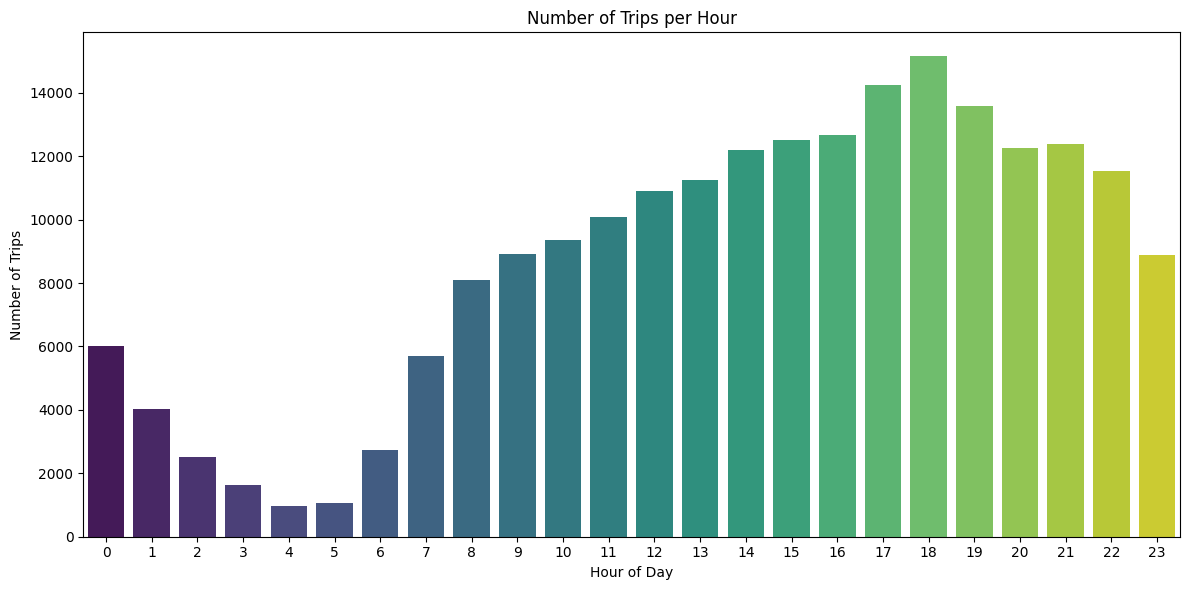

The busiest hour is: 18:00 with 15150 trips.


In [420]:
# Visualise the number of trips per hour and find the busiest hour
# Count number of trips for each hour
hourly_trips = df_merged['pickup_hour'].value_counts().sort_index()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=hourly_trips.index, y=hourly_trips.values, palette='viridis')
plt.title("Number of Trips per Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

# Find busiest hour
busiest_hour = hourly_trips.idxmax()
print(f"The busiest hour is: {busiest_hour}:00 with {hourly_trips.max()} trips.")


Remember, we took a fraction of trips. To find the actual number, you have to scale the number up by the sampling ratio.

**3.2.3** 
Find the actual number of trips in the five busiest hours

In [422]:
# Scale up the number of trips

# Fill in the value of your sampling fraction and use that to scale up the numbers 
sample_fraction = 0.0075
# First, find the top 5 busiest hours in the sample
top_5_busiest_hours = hourly_trips.nlargest(5)

# Print the busiest hours and estimated trips in the whole dataset
for hour, trips in top_5_busiest_hours.items():
    estimated_trips = trips / 0.0075  # scale up by the sampling ratio
    print(f"Busiest hour: {hour}:00 with {trips} trips in the sample, estimated total trips: {estimated_trips:.0f}")


Busiest hour: 18:00 with 15150 trips in the sample, estimated total trips: 2020000
Busiest hour: 17:00 with 14251 trips in the sample, estimated total trips: 1900133
Busiest hour: 19:00 with 13583 trips in the sample, estimated total trips: 1811067
Busiest hour: 16:00 with 12666 trips in the sample, estimated total trips: 1688800
Busiest hour: 15:00 with 12521 trips in the sample, estimated total trips: 1669467


**3.2.4** 
Compare hourly traffic pattern on weekdays. Also compare for weekend.

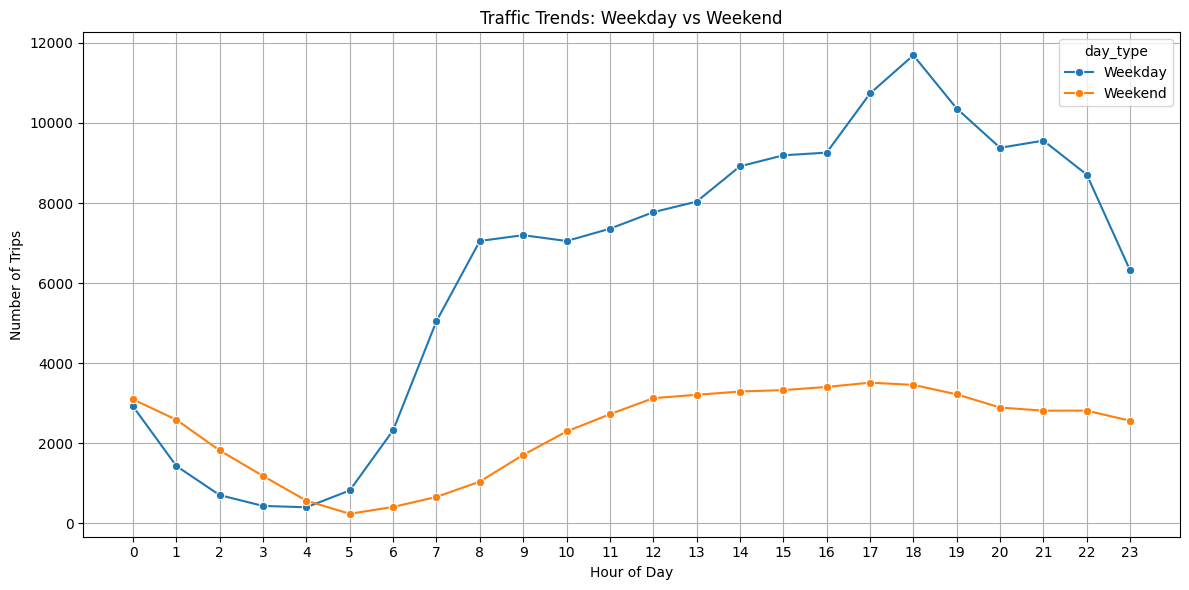

In [424]:
# Compare traffic trends for the week days and weekends

# Step 1: Create a new column for the day of the week
df_merged['day_of_week'] = df_merged['tpep_pickup_datetime'].dt.day_name()

# Step 2: Create a column to categorize into Weekday or Weekend
df_merged['day_type'] = df_merged['day_of_week'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')

# Step 3: Count the number of trips for each day type and hour
traffic_trends = df_merged.groupby(['day_type', 'pickup_hour']).size().reset_index(name='trip_count2')

# Step 4: Plot the trends


plt.figure(figsize=(12, 6))
sns.lineplot(data=traffic_trends, x='pickup_hour', y='trip_count2', hue='day_type', marker='o')
plt.title('Traffic Trends: Weekday vs Weekend')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()


What can you infer from the above patterns? How will finding busy and quiet hours for each day help us?

**3.2.5** 
Identify top 10 zones with high hourly pickups. Do the same for hourly dropoffs. Show pickup and dropoff trends in these zones.

In [440]:
# Find top 10 pickup and dropoff zones

top10_pickups = df_merged['PULocationID'].value_counts().head(10)

# For pickup zones
top10_pickups = top10_pickups.reset_index()
top10_pickups.columns = ['LocationID', 'Pickup_Count']
top10_pickups = top10_pickups.merge(zones[['LocationID', 'zone']], on='LocationID', how='left')
print("Top 10 Pickup Zones:")
print(top10_pickups)

Top 10 Pickup Zones:
   LocationID  Pickup_Count                          zone
0         161          9899                Midtown Center
1         237          9761         Upper East Side South
2         132          9587                   JFK Airport
3         236          8789         Upper East Side North
4         162          7911                  Midtown East
5         138          7645             LaGuardia Airport
6         186          7208  Penn Station/Madison Sq West
7         142          7180           Lincoln Square East
8         230          6629     Times Sq/Theatre District
9         170          6362                   Murray Hill


In [442]:
top10_dropoffs = df_merged['DOLocationID'].value_counts().head(10)


# For dropoff zones
top10_dropoffs = top10_dropoffs.reset_index()
top10_dropoffs.columns = ['LocationID', 'Dropoff_Count']
top10_dropoffs = top10_dropoffs.merge(zones[['LocationID', 'zone']], on='LocationID', how='left')
print("\nTop 10 Dropoff Zones:")
print(top10_dropoffs)


Top 10 Dropoff Zones:
   LocationID  Dropoff_Count                       zone
0         236           9431      Upper East Side North
1         237           8495      Upper East Side South
2         161           8206             Midtown Center
3         170           6418                Murray Hill
4         239           6206      Upper West Side South
5         142           6133        Lincoln Square East
6         162           6074               Midtown East
7         141           5780            Lenox Hill West
8         230           5777  Times Sq/Theatre District
9          68           5343               East Chelsea


**3.2.6** 
Find the ratio of pickups and dropoffs in each zone. Display the 10 highest (pickup/drop) and 10 lowest (pickup/drop) ratios.

In [460]:
# Find the top 10 and bottom 10 pickup/dropoff ratios


# Step 1: Compute pickup and dropoff ratios
pickup_ratios = df_merged['PULocationID'].value_counts(normalize=True).reset_index()
pickup_ratios.columns = ['LocationID', 'pickup_ratio']

dropoff_ratios = df_merged['DOLocationID'].value_counts(normalize=True).reset_index()
dropoff_ratios.columns = ['LocationID', 'dropoff_ratio']

# Step 2: Merge with zones dataframe
pickup_zones = pickup_ratios.merge(zones[['LocationID', 'zone']], on='LocationID', how='left')
dropoff_zones = dropoff_ratios.merge(zones[['LocationID', 'zone']], on='LocationID', how='left')

# Step 3: Sort and display
top10_pickup_zones = pickup_zones.sort_values('pickup_ratio', ascending=False).head(10)
bottom10_pickup_zones = pickup_zones.sort_values('pickup_ratio', ascending=True).head(10)

top10_dropoff_zones = dropoff_zones.sort_values('dropoff_ratio', ascending=False).head(10)
bottom10_dropoff_zones = dropoff_zones.sort_values('dropoff_ratio', ascending=True).head(10)

print('\nTop 10 pickup zones ratio:')
print(top10_pickup_zones)





Top 10 pickup zones ratio:
   LocationID  pickup_ratio                          zone
0         161      0.047442                Midtown Center
1         237      0.046781         Upper East Side South
2         132      0.045947                   JFK Airport
3         236      0.042122         Upper East Side North
4         162      0.037914                  Midtown East
5         138      0.036639             LaGuardia Airport
6         186      0.034545  Penn Station/Madison Sq West
7         142      0.034411           Lincoln Square East
8         230      0.031770     Times Sq/Theatre District
9         170      0.030491                   Murray Hill


In [454]:
print('\n Bottom 10 pickup zones ratio:')
print(bottom10_pickup_zones)



 Bottom 10 pickup zones ratio:
     LocationID  pickup_ratio                zone
171         169      0.000005          Mount Hope
151           9      0.000005          Auburndale
150          47      0.000005  Claremont/Bathgate
149         150      0.000005     Manhattan Beach
148         185      0.000005      Pelham Parkway
147         123      0.000005           Homecrest
146          22      0.000005    Bensonhurst West
152           1      0.000005      Newark Airport
145         203      0.000005            Rosedale
143         227      0.000005    Sunset Park East


In [464]:
print('\n Top 10 dropoff zones ratio:')
print(top10_dropoff_zones)


 Top 10 dropoff zones ratio:
   LocationID  dropoff_ratio                       zone
0         236       0.045199      Upper East Side North
1         237       0.040713      Upper East Side South
2         161       0.039328             Midtown Center
3         170       0.030759                Murray Hill
4         239       0.029743      Upper West Side South
5         142       0.029393        Lincoln Square East
6         162       0.029110               Midtown East
7         141       0.027701            Lenox Hill West
8         230       0.027687  Times Sq/Theatre District
9          68       0.025607               East Chelsea


In [456]:
print('\n Bottom 10 dropoff zones ratio:')
print(bottom10_dropoff_zones)


 Bottom 10 dropoff zones ratio:
     LocationID  dropoff_ratio                     zone
247           5       0.000005            Arden Heights
237         204       0.000005        Rossville/Woodrow
238         153       0.000005              Marble Hill
239         240       0.000005       Van Cortlandt Park
240         184       0.000005          Pelham Bay Park
246         221       0.000005                Stapleton
242         109       0.000005              Great Kills
243           6       0.000005  Arrochar/Fort Wadsworth
244         253       0.000005            Willets Point
245         183       0.000005               Pelham Bay


**3.2.7** 
Identify zones with high pickup and dropoff traffic during night hours (11PM to 5AM)

In [472]:
# During night hours (11pm to 5am) find the top 10 pickup and dropoff zones
# Note that the top zones should be of night hours and not the overall top zones

# Step 1: Create dropoff_hour column
df_merged['dropoff_hour'] = df_merged['tpep_dropoff_datetime'].dt.hour

# Step 2: Filter for night hours (11 PM to 5 AM)
pickup_night_df = df_merged[df_merged['pickup_hour'].isin([23, 0, 1, 2, 3, 4, 5])]
dropoff_night_df = df_merged[df_merged['dropoff_hour'].isin([23, 0, 1, 2, 3, 4, 5])]

# Step 3: Get top 10 pickup and dropoff LocationIDs
top_pickups = pickup_night_df['PULocationID'].value_counts().head(10).reset_index()
top_dropoffs = dropoff_night_df['DOLocationID'].value_counts().head(10).reset_index()

# Step 4: Rename columns for clarity
top_pickups.columns = ['LocationID', 'Pickup_Count']
top_dropoffs.columns = ['LocationID', 'Dropoff_Count']

# Step 5: Merge with zones to get Zone names
top_pickups_named = top_pickups.merge(zones, on='LocationID')[['zone', 'Pickup_Count']]
top_dropoffs_named = top_dropoffs.merge(zones, on='LocationID')[['zone', 'Dropoff_Count']]

# Step 6: Display
print("Top 10 Pickup Zones during Night Hours:")
print(top_pickups_named)

print("\nTop 10 Dropoff Zones during Night Hours:")
print(top_dropoffs_named)



Top 10 Pickup Zones during Night Hours:
                           zone  Pickup_Count
0                  East Village          1905
1                  West Village          1645
2                   JFK Airport          1458
3               Lower East Side          1240
4                  Clinton East          1156
5       Greenwich Village South          1074
6     Times Sq/Theatre District           938
7  Penn Station/Madison Sq West           793
8             LaGuardia Airport           742
9                      Gramercy           708

Top 10 Dropoff Zones during Night Hours:
                    zone  Dropoff_Count
0           East Village           1033
1           Clinton East            820
2            Murray Hill            813
3               Gramercy            757
4        Lenox Hill West            755
5           East Chelsea            738
6         Yorkville West            730
7  Upper East Side North            671
8           West Village            643
9  Upper Wes

Now, let us find the revenue share for the night time hours and the day time hours. After this, we will move to deciding a pricing strategy.

**3.2.8** 
Find the revenue share for nighttime and daytime hours.

In [476]:
# Filter for night hours (11 PM to 5 AM)
# Define night and day hours
night_hours = [23, 0, 1, 2, 3, 4, 5]

# Create a new column for time of day
df_merged['time_of_day'] = df_merged['pickup_hour'].apply(lambda x: 'Night' if x in night_hours else 'Day')

# Group by time of day and sum revenue
revenue_share = df_merged.groupby('time_of_day')['total_amount'].sum()

# Normalize to get percentage share
revenue_percent = (revenue_share / revenue_share.sum()) * 100

# Display
print("Revenue Share Percent by Time of Day:")
print(revenue_percent)



Revenue Share Percent by Time of Day:
time_of_day
Day      87.790687
Night    12.209313
Name: total_amount, dtype: float64


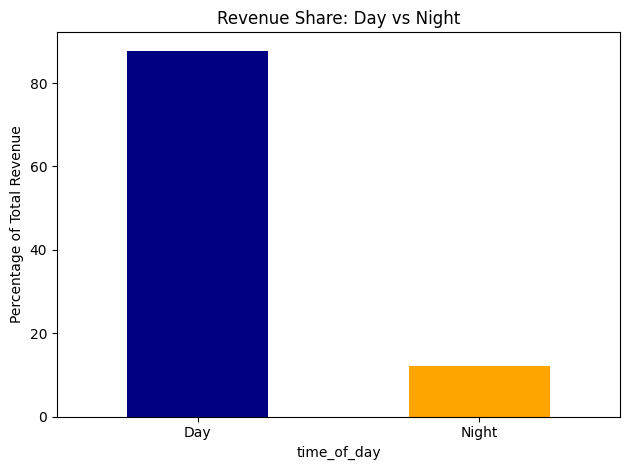

In [478]:

revenue_percent.plot(kind='bar', color=['navy', 'orange'])
plt.title('Revenue Share: Day vs Night')
plt.ylabel('Percentage of Total Revenue')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


##### Pricing Strategy

**3.2.9** 
For the different passenger counts, find the average fare per mile per passenger.

For instance, suppose the average fare per mile for trips with 3 passengers is 3 USD/mile, then the fare per mile per passenger will be 1 USD/mile.

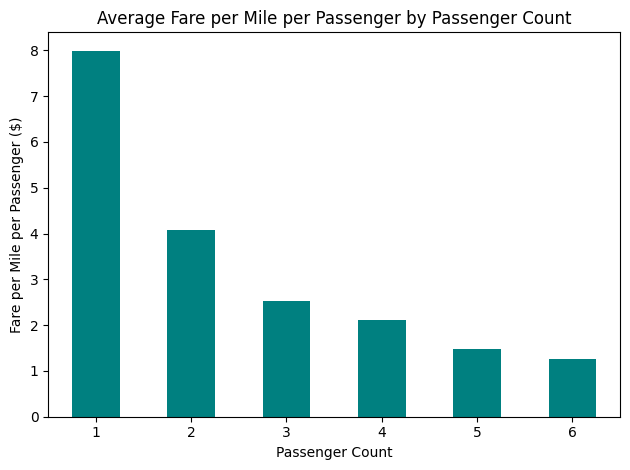

In [480]:
# Analyse the fare per mile per passenger for different passenger counts

# Filter out invalid rows
valid_df = df_merged[(df_merged['trip_distance'] > 0) & (df_merged['passenger_count'] > 0)]

# Compute fare per mile per passenger
valid_df['fare_per_mile_per_passenger'] = valid_df['fare_amount'] / (valid_df['trip_distance'] * valid_df['passenger_count'])

# Group by passenger count and take average fare per mile per passenger
fare_analysis = valid_df.groupby('passenger_count')['fare_per_mile_per_passenger'].mean().sort_index()

# Plot
fare_analysis.plot(kind='bar', color='teal')
plt.title('Average Fare per Mile per Passenger by Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Fare per Mile per Passenger ($)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



**3.2.10** 
Find the average fare per mile by hours of the day and by days of the week

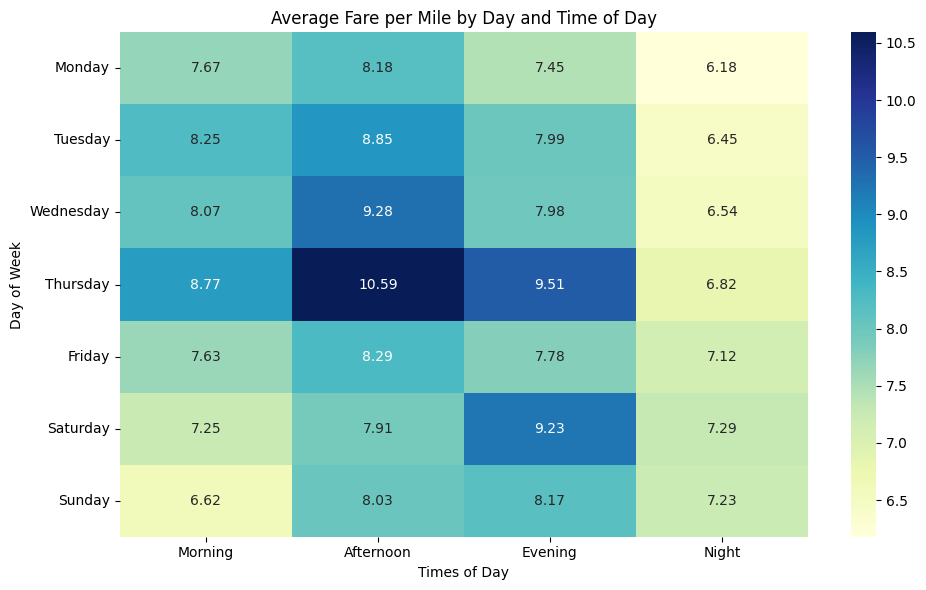

In [503]:
# Compare the average fare per mile for different days and for different times of the day

# Step 1: Compute fare per mile
df_merged['fare_per_mile'] = df_merged['fare_amount'] / df_merged['trip_distance']

# Step 2: Group and compute average fare per mile
grouped = df_merged.groupby(['day_of_week', 'times_of_day'])['fare_per_mile'].mean().reset_index()

# Step 3: Pivot for heatmap
fare_matrix = grouped.pivot(index='day_of_week', columns='times_of_day', values='fare_per_mile')

#Ensure the correct order of days and times
fare_matrix = fare_matrix.reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])
fare_matrix = fare_matrix[['Morning', 'Afternoon', 'Evening', 'Night']]

# Step 4: Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(fare_matrix, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Average Fare per Mile by Day and Time of Day")
plt.xlabel("Times of Day")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()



**3.2.11** 
Analyse the average fare per mile for the different vendors for different hours of the day

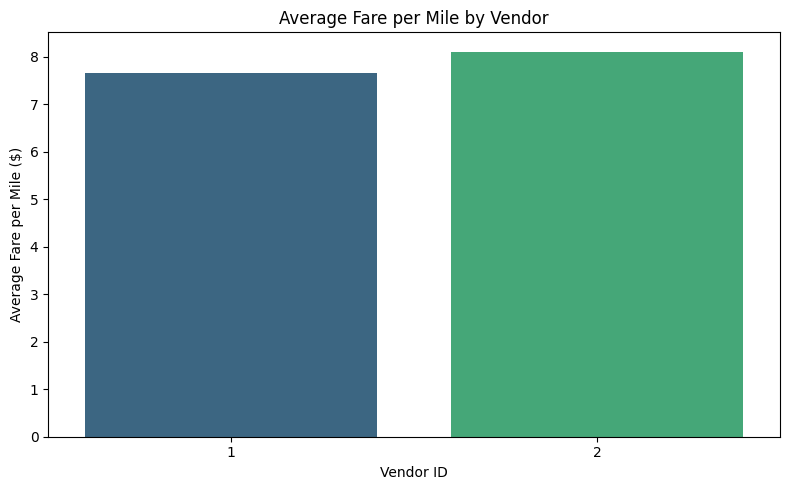

In [505]:
# Compare fare per mile for different vendors

# Step 1: Group by VendorID and calculate average fare per mile
vendor_fare = df_merged.groupby('VendorID')['fare_per_mile'].mean().reset_index()

# Step 2: Plot the comparison
plt.figure(figsize=(8,5))
sns.barplot(data=vendor_fare, x='VendorID', y='fare_per_mile', palette='viridis')
plt.title('Average Fare per Mile by Vendor')
plt.xlabel('Vendor ID')
plt.ylabel('Average Fare per Mile ($)')
plt.tight_layout()
plt.show()


**3.2.12** 
Compare the fare rates of the different vendors in a tiered fashion. Analyse the average fare per mile for distances upto 2 miles. Analyse the fare per mile for distances from 2 to 5 miles. And then for distances more than 5 miles.


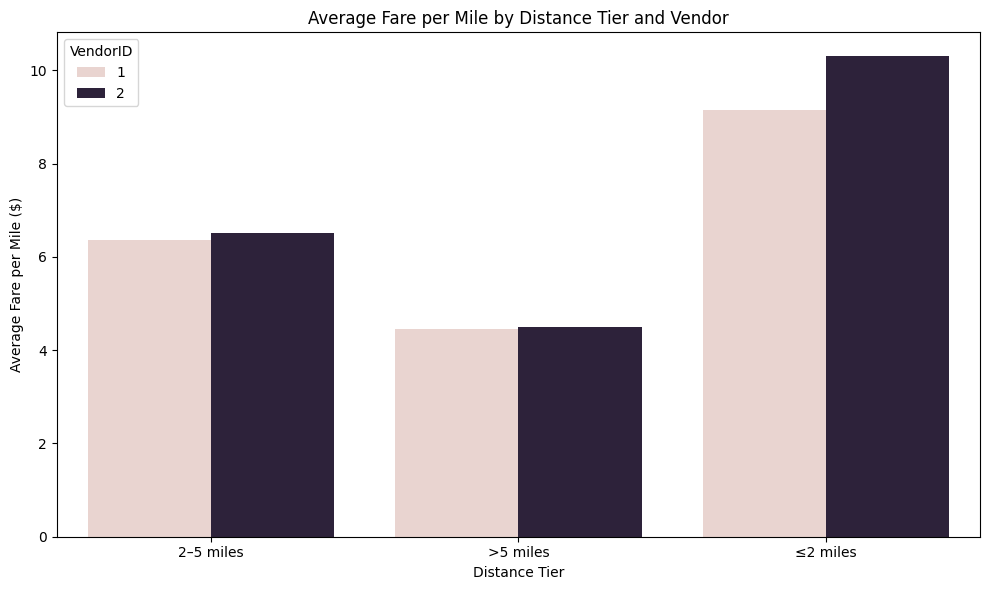

In [507]:
# Defining distance tiers

# Step 1: Define distance tiers
def distance_tier(dist):
    if dist <= 2:
        return '≤2 miles'
    elif 2 < dist <= 5:
        return '2–5 miles'
    else:
        return '>5 miles'

df_merged['distance_tier'] = df_merged['trip_distance'].apply(distance_tier)

# Step 2: Group by Vendor and distance tier
tiered_fare = df_merged.groupby(['VendorID', 'distance_tier'])['fare_per_mile'].mean().reset_index()

# Step 3: Visualize
plt.figure(figsize=(10, 6))
sns.barplot(data=tiered_fare, x='distance_tier', y='fare_per_mile', hue='VendorID')
plt.title('Average Fare per Mile by Distance Tier and Vendor')
plt.xlabel('Distance Tier')
plt.ylabel('Average Fare per Mile ($)')
plt.tight_layout()
plt.show()



##### Customer Experience and Other Factors

**3.2.13** 
Analyse average tip percentages based on trip distances, passenger counts and time of pickup. What factors lead to low tip percentages?

<Axes: title={'center': 'Tip % by Distance Tier'}, xlabel='distance_tier'>

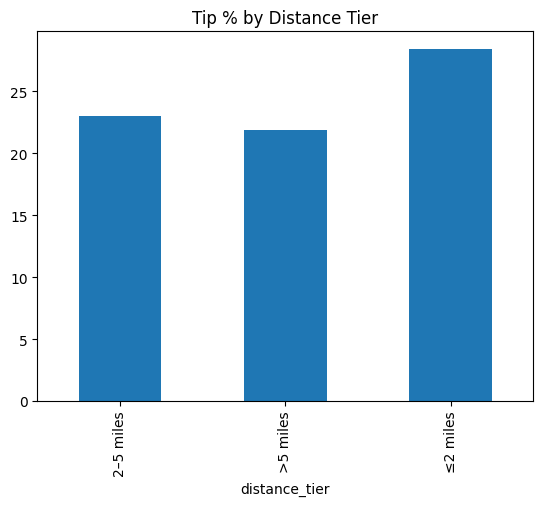

In [509]:
#  Analyze tip percentages based on distances, passenger counts and pickup times

df_merged['tip_percent'] = (df_merged['tip_amount'] / df_merged['fare_amount']) * 100

# Average tip percent by distance tier
df_merged.groupby('distance_tier')['tip_percent'].mean().plot(kind='bar', title='Tip % by Distance Tier')



<Axes: title={'center': 'Tip % by Passenger Count'}, xlabel='passenger_count'>

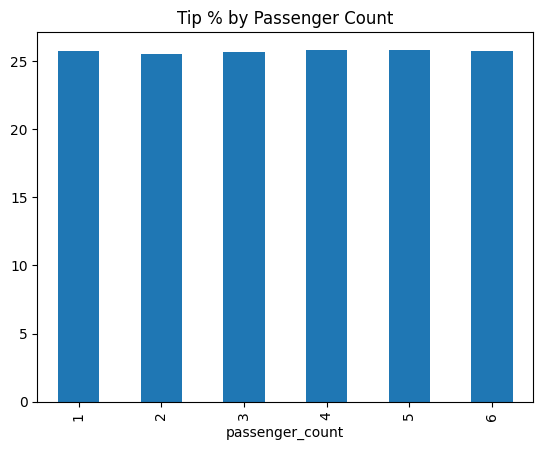

In [511]:
# Average tip percent by Passenger Count
df_merged.groupby('passenger_count')['tip_percent'].mean().plot(kind='bar', title='Tip % by Passenger Count')


<Axes: title={'center': 'Tip % by Time of Day'}, xlabel='times_of_day'>

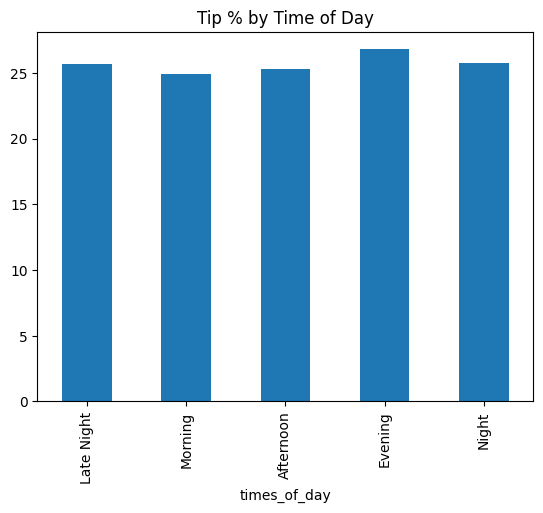

In [513]:
# Average tip percent by time of the day
df_merged.groupby('times_of_day')['tip_percent'].mean().plot(kind='bar', title='Tip % by Time of Day')


Additional analysis [optional]: Let's try comparing cases of low tips with cases of high tips to find out if we find a clear aspect that drives up the tipping behaviours

In [515]:
# Compare trips with tip percentage < 10% to trips with tip percentage > 25%


# Step 1: Filter two groups
low_tip = df_merged[df_merged['tip_percent'] < 10]
high_tip = df_merged[df_merged['tip_percent'] > 25]

# Step 2: Compare key metrics
print("Low Tip Trips (Tip % < 10%)")
print(low_tip[['fare_amount', 'trip_distance', 'passenger_count']].describe())

print("\nHigh Tip Trips (Tip % > 25%)")
print(high_tip[['fare_amount', 'trip_distance', 'passenger_count']].describe())


Low Tip Trips (Tip % < 10%)
        fare_amount  trip_distance  passenger_count
count  11629.000000   11629.000000     11629.000000
mean      26.237840       4.931169         1.357898
std       21.462917       5.665368         0.857113
min        4.400000       0.020000         1.000000
25%       13.500000       1.760000         1.000000
50%       19.100000       2.760000         1.000000
75%       29.600000       5.370000         1.000000
max      365.600000     187.350000         6.000000

High Tip Trips (Tip % > 25%)
         fare_amount  trip_distance  passenger_count
count  117133.000000  117133.000000    117133.000000
mean       14.740132       2.379698         1.358174
std        11.653827       2.940184         0.859108
min         0.510000       0.010000         1.000000
25%         8.600000       1.000000         1.000000
50%        11.400000       1.500000         1.000000
75%        15.600000       2.300000         1.000000
max       332.700000      56.500000         6.0000

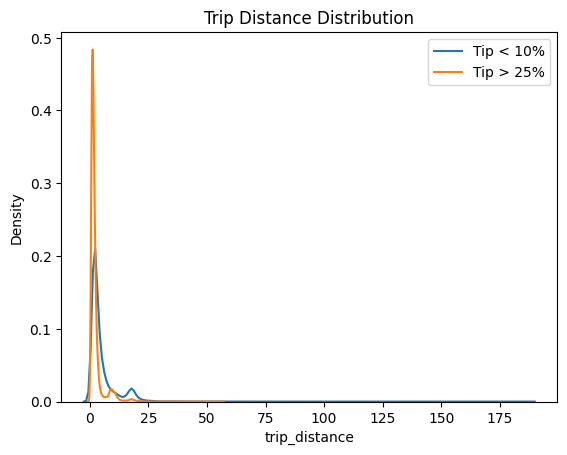

In [517]:
# Trip Distance Comparison
sns.kdeplot(low_tip['trip_distance'], label='Tip < 10%')
sns.kdeplot(high_tip['trip_distance'], label='Tip > 25%')
plt.title('Trip Distance Distribution')
plt.legend()
plt.show()


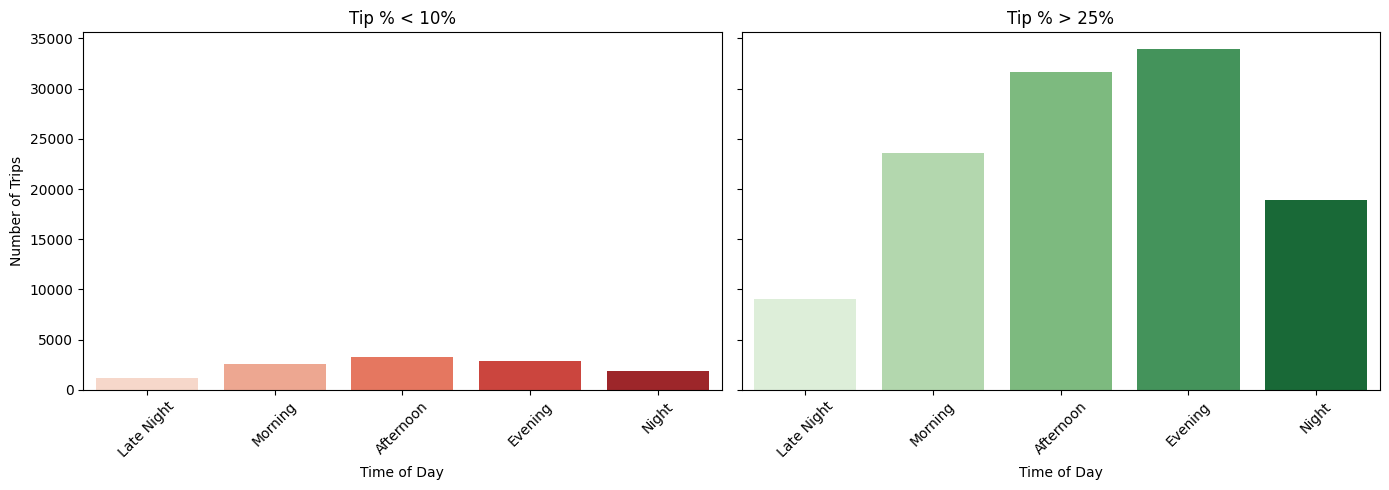

In [525]:

# Set up figure and axes
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Plot for Tip < 10%
sns.countplot(
    data=df_merged[df_merged['tip_percent'] < 10],
    x='times_of_day',
    ax=axes[0],
    palette='Reds'
)
axes[0].set_title('Tip % < 10%')
axes[0].set_xlabel('Time of Day')
axes[0].set_ylabel('Number of Trips')
axes[0].tick_params(axis='x', rotation=45)

# Plot for Tip > 25%
sns.countplot(
    data=df_merged[df_merged['tip_percent'] > 25],
    x='times_of_day',
    ax=axes[1],
    palette='Greens'
)
axes[1].set_title('Tip % > 25%')
axes[1].set_xlabel('Time of Day')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



**3.2.14** 
Analyse the variation of passenger count across hours and days of the week.

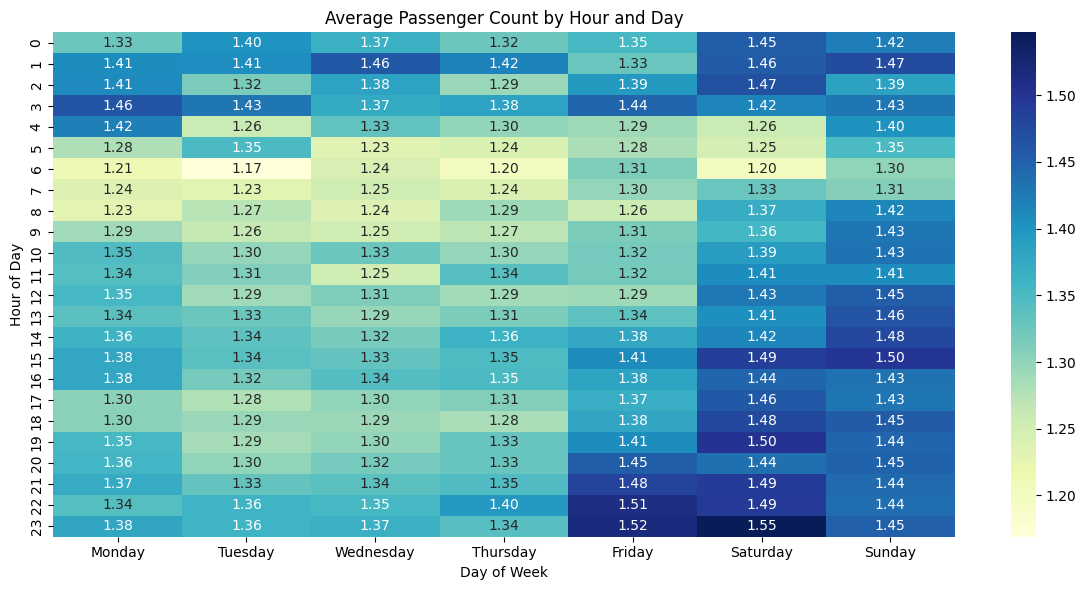

In [531]:
# See how passenger count varies across hours and days


# Ensure day_of_week is ordered correctly
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_merged['day_of_week'] = pd.Categorical(df_merged['day_of_week'], categories=day_order, ordered=True)

# Create a pivot table of average passenger count
passenger_heatmap = df_merged.pivot_table(
    index='pickup_hour',
    columns='day_of_week',
    values='passenger_count',
    aggfunc='mean'
)

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(passenger_heatmap, cmap='YlGnBu', annot=True, fmt=".2f")
plt.title('Average Passenger Count by Hour and Day')
plt.xlabel('Day of Week')
plt.ylabel('Hour of Day')
plt.tight_layout()
plt.show()




**3.2.15** 
Analyse the variation of passenger counts across zones

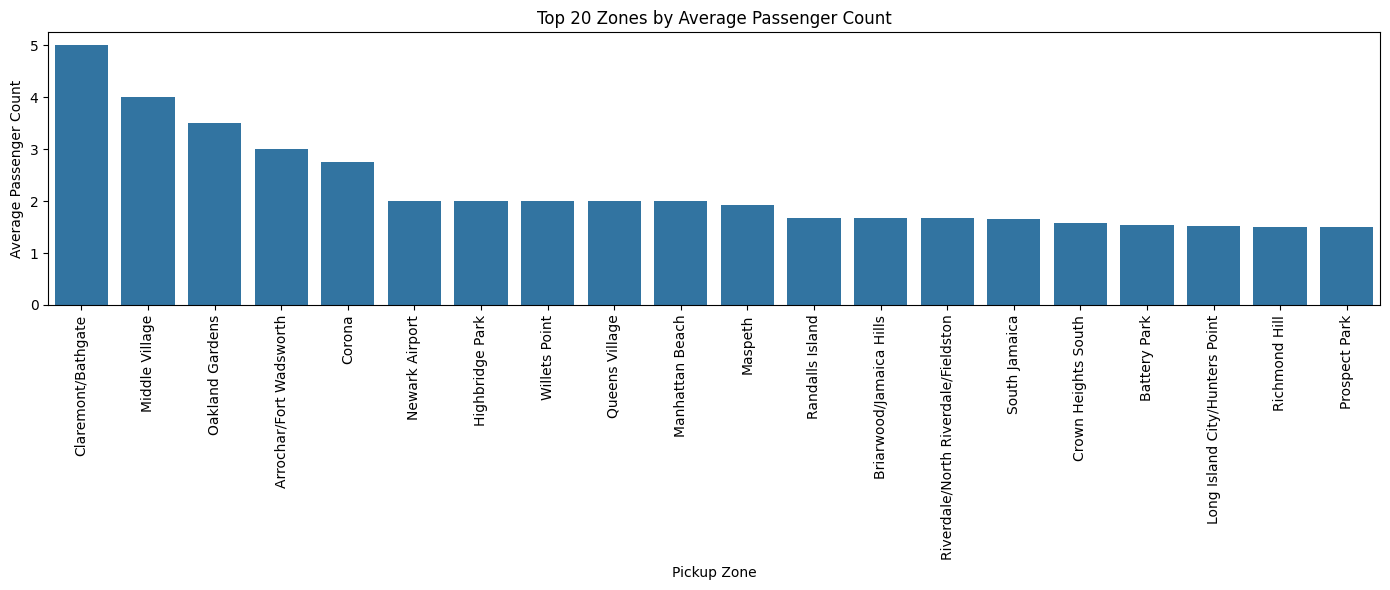

In [535]:
# How does passenger count vary across zones

# Group by pickup zone and calculate average passenger count
zone_passenger_avg = df_merged.groupby('zone')['passenger_count'].mean().sort_values(ascending=False)

# Plot the top 20 zones with highest average passenger count
plt.figure(figsize=(14, 6))
sns.barplot(x=zone_passenger_avg.head(20).index, y = zone_passenger_avg.head(20).values)
plt.xticks(rotation=90)
plt.title('Top 20 Zones by Average Passenger Count')
plt.ylabel('Average Passenger Count')
plt.xlabel('Pickup Zone')
plt.tight_layout()
plt.show()



<Figure size 1200x1000 with 0 Axes>

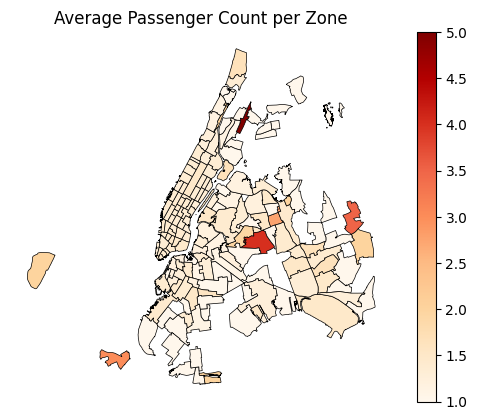

In [539]:
# For a more detailed analysis, we can use the zones_with_trips GeoDataFrame
# Create a new column for the average passenger count in each zone.

# Step 1: Compute average passenger count per zone
avg_passenger = df_merged.groupby('zone')['passenger_count'].mean().reset_index()
avg_passenger.rename(columns={'passenger_count': 'avg_passenger_count'}, inplace=True)

# Step 2: Merge with the zones GeoDataFrame
zones_with_avg_passenger = zones.merge(avg_passenger, on='zone', how='left')

# Step 3: Plot the result
plt.figure(figsize=(12, 10))
zones_with_avg_passenger.plot(column='avg_passenger_count',
                               cmap='OrRd',
                               legend=True,
                               edgecolor='black',
                               linewidth=0.5)
plt.title("Average Passenger Count per Zone")
plt.axis('off')
plt.show()


Find out how often surcharges/extra charges are applied to understand their prevalance

**3.2.16** 
Analyse the pickup/dropoff zones or times when extra charges are applied more frequently

In [552]:
# How often is each surcharge applied?

#Pickup zones with highest average extra charges
pickup_extra = df_merged.groupby('zone')['extra'].mean().sort_values(ascending=False)
pickup_extra.head(10)  # Top 10 zones by average extra



zone
LaGuardia Airport    6.284931
East Elmhurst        4.792864
City Island          2.500000
Auburndale           2.500000
Roosevelt Island     2.500000
College Point        2.500000
Randalls Island      2.083333
Jackson Heights      1.960526
Corona               1.875000
Kew Gardens          1.875000
Name: extra, dtype: float64

In [561]:
#Time of day when extra charges are high
time_extra = df_merged.groupby('times_of_day')['extra'].mean().sort_values(ascending=False)
time_extra

times_of_day
Evening       2.501530
Night         1.741158
Late Night    1.610478
Afternoon     1.348519
Morning       0.973260
Name: extra, dtype: float64

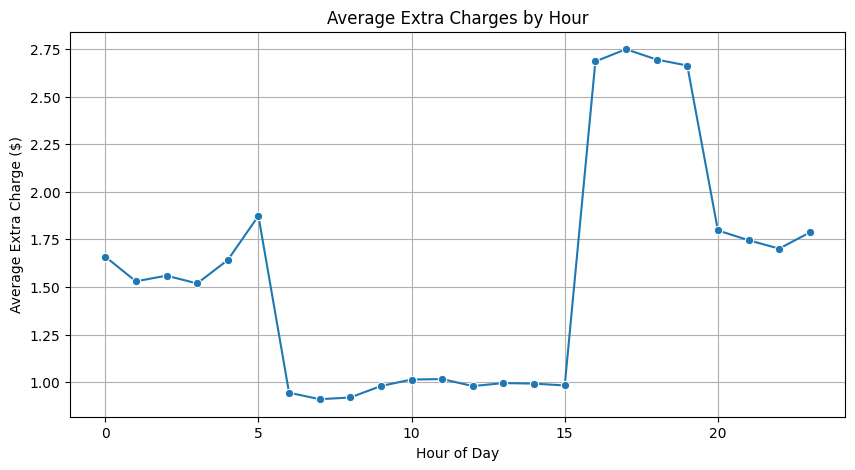

In [563]:
hourly_extra = df_merged.groupby('pickup_hour')['extra'].mean()

plt.figure(figsize=(10,5))
sns.lineplot(x=hourly_extra.index, y=hourly_extra.values, marker='o')
plt.title('Average Extra Charges by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Extra Charge ($)')
plt.grid(True)
plt.show()


## **4** Conclusion


### **4.1** Final Insights and Recommendations


Conclude your analyses here. Include all the outcomes you found based on the analysis.

Based on the insights, frame a concluding story explaining suitable parameters such as location, time of the day, day of the week etc. to be kept in mind while devising a strategy to meet customer demand and optimise supply.

**4.1.1** 
Recommendations to optimize routing and dispatching based on demand patterns and operational inefficiencies

**4.1.2** 

Suggestions on strategically positioning cabs across different zones to make best use of insights uncovered by analysing trip trends across time, days and months.

**4.1.3** 
Propose data-driven adjustments to the pricing strategy to maximize revenue while maintaining competitive rates with other vendors.